# Squats from Excel

In [165]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy.integrate import cumulative_trapezoid

Ladder in data.

In [166]:
unityDF = pd.read_csv("unitydata (1).csv")
originalUnityDF = unityDF.copy()

#wiiFitDF = pd.read_csv("my_values.csv")
wiiFitDF = pd.read_csv("my_values_fast_wiifit.csv")


Wii Fit värdena anges i [kg] just nu så de måste multipliceras med 9,82 för att vi ska få kraftutslaget.  
Sedan behöver vi byta ut kolumnnamnen så kod kan återanvändas.

In [167]:
g = 9.82 
shift = 0.7 # [kg]

wiiFitDF['Value'] = wiiFitDF['Value'].map(lambda x: (x+shift)*g)
wiiFitDF.rename(columns={wiiFitDF.columns[0]:unityDF.columns[0], wiiFitDF.columns[1]:unityDF.columns[1]}, inplace=True)
display(wiiFitDF.head())

time     force
0  3.63  406.1552
1  3.81  621.8024
2  3.97  769.6916
3  4.13  807.8914
4  4.30  823.1124

In [168]:

rowsToDeleteUnity = 20
#rowsToDeleteWiiFit = 59
rowsToDeleteWiiFit = 180


wiiFitDF.drop(index=range(0, rowsToDeleteWiiFit), inplace=True)
wiiFitDF = wiiFitDF.reset_index()

unityDF.drop(index=range(0, rowsToDeleteUnity), inplace=True)
unityDF = unityDF.reset_index()

    

Tar bort dötid

In [169]:
unityDF.drop(columns=['index'], inplace=True)
wiiFitDF.drop(columns=['index'], inplace=True)

display(unityDF.head())
display(wiiFitDF.head())

time   force
0  3.34  834.79
1  3.50  834.52
2  3.66  834.69
3  3.82  834.80
4  3.98  834.63

time     force
0  36.26  845.9930
1  36.43  847.0732
2  36.59  843.3416
3  36.77  845.6002
4  36.96  849.5282

In [170]:
X_1 = unityDF['time'].loc[0]
X_2 = wiiFitDF['time'].loc[0]

print(f"All Unity 'time' shifted back by: {X_1} [s]")
print(f"All Wii Fit 'time' shifted back by: {X_2} [s]")


unityDF['time'] = unityDF['time'].map(lambda x: (x-X_1))
wiiFitDF['time'] = wiiFitDF['time'].map(lambda x: (x-X_2))
display("Unity",unityDF.head(), "Wii Fit" , wiiFitDF.head())


All Unity 'time' shifted back by: 3.34 [s]
All Wii Fit 'time' shifted back by: 36.26 [s]


'Unity'

time   force
0  0.00  834.79
1  0.16  834.52
2  0.32  834.69
3  0.48  834.80
4  0.64  834.63

'Wii Fit'

time     force
0  0.00  845.9930
1  0.17  847.0732
2  0.33  843.3416
3  0.51  845.6002
4  0.70  849.5282

Visar upp alla data-punkter

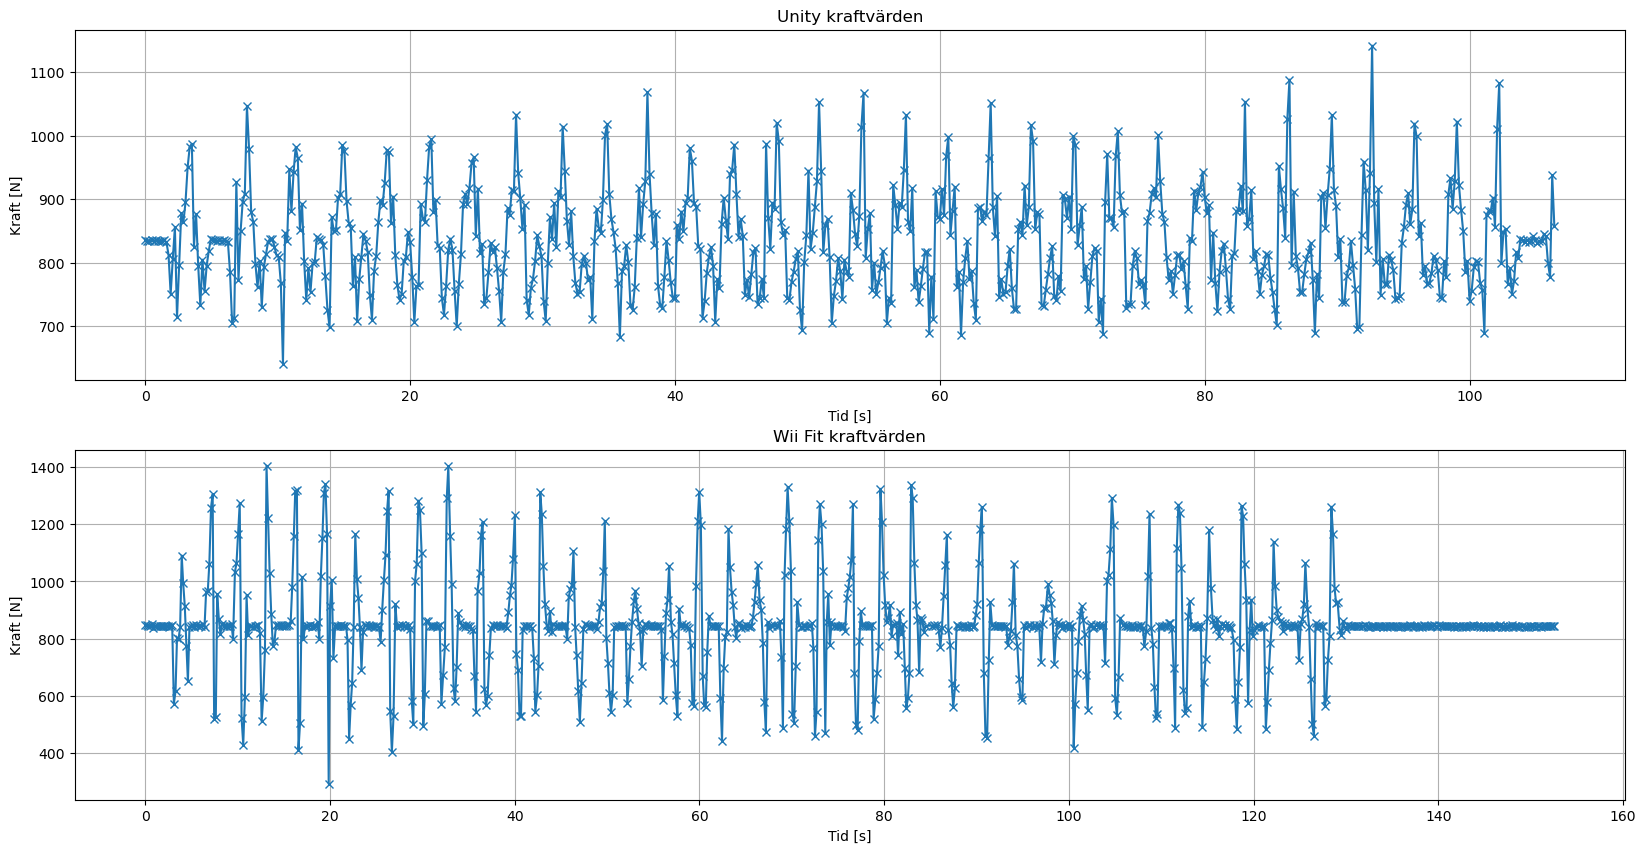

In [171]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

ax1.plot(unityDF['time'], unityDF['force'], marker="x")
#ax.plot(originalUnityDF['time'], originalUnityDF['force'], linestyle='dashed', color = "green")
ax1.set_xlabel("Tid [s]")
ax1.set_ylabel("Kraft [N]")
ax1.set_title("Unity kraftvärden")
ax1.grid()

ax2.plot(wiiFitDF['time'], wiiFitDF['force'], marker="x")
ax2.set_xlabel("Tid [s]")
ax2.set_ylabel("Kraft [N]")
ax2.set_title("Wii Fit kraftvärden")
ax2.grid()
plt.show()

Möjligtvis inttresant [[Källa]](https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html)

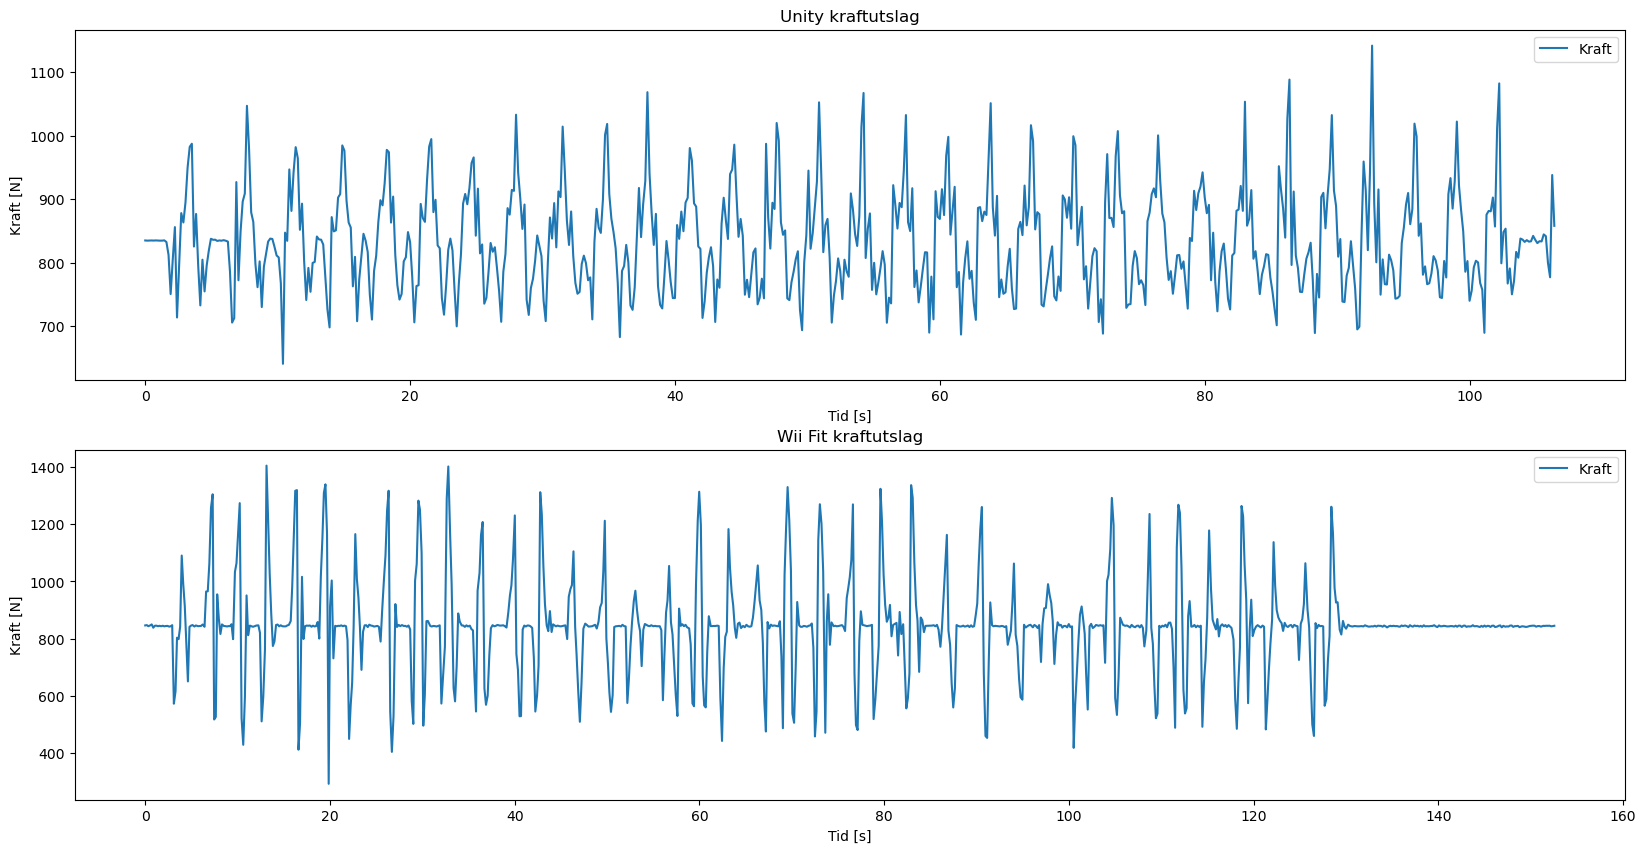

In [172]:

fig, (ax1, ax2) = plt.subplots( 2, 1, figsize=(20,10))

ax1.plot(unityDF['time'], unityDF['force'], label="Kraft")
ax1.set_xlabel("Tid [s]")
ax1.set_ylabel("Kraft [N]")
ax1.set_title("Unity kraftutslag")
ax1.legend()

ax2.plot(wiiFitDF['time'], wiiFitDF['force'], label="Kraft")
ax2.set_xlabel("Tid [s]")
ax2.set_ylabel("Kraft [N]")
ax2.set_title("Wii Fit kraftutslag")
ax2.legend()

plt.show()

#plt.plot(data['time'], data['force'])
#plt.figure().set_size_inches(2000, 10, forward=True)
#plt.show()

Om man lägger de på varandra ges följande.

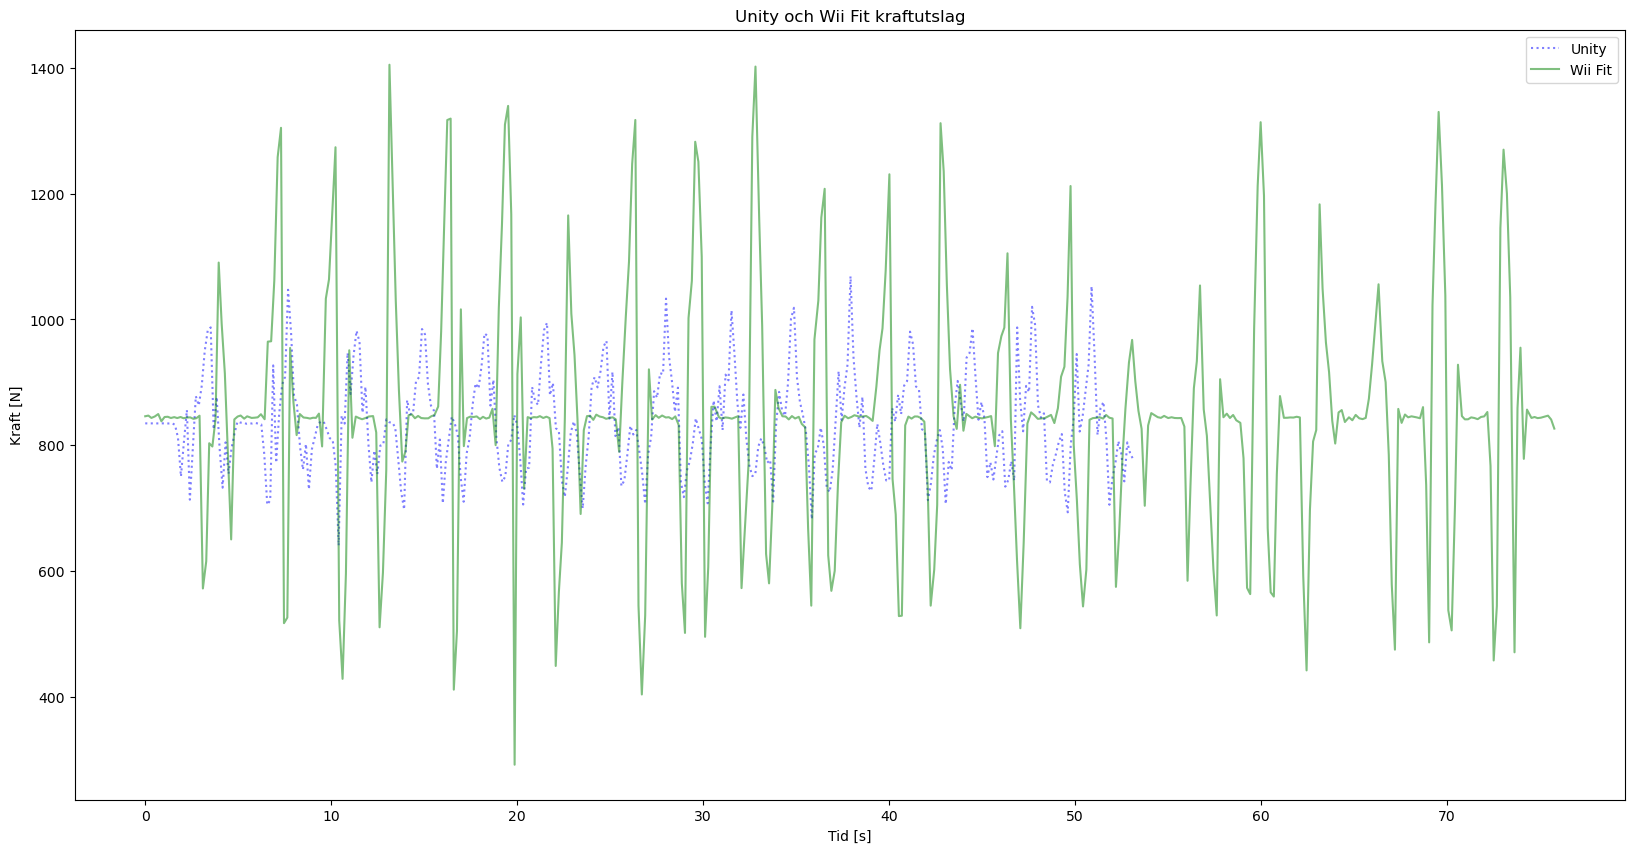

In [173]:

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(unityDF['time'][0:int(unityDF.shape[0]/2)], unityDF['force'][0:int(unityDF.shape[0]/2)], label="Unity", linestyle="dotted", color="blue", alpha=0.5)
ax.plot(wiiFitDF['time'][0:int(wiiFitDF.shape[0]/2)], wiiFitDF['force'][0:int(wiiFitDF.shape[0]/2)], label="Wii Fit", linestyle="solid", color="green", alpha=0.5)


ax.set_title("Unity och Wii Fit kraftutslag")
ax.set_xlabel("Tid [s]")
ax.set_ylabel("Kraft [N]")
ax.legend()



plt.show()

#plt.plot(data['time'], data['force'])
#plt.figure().set_size_inches(2000, 10, forward=True)
#plt.show()

## Area beräkning

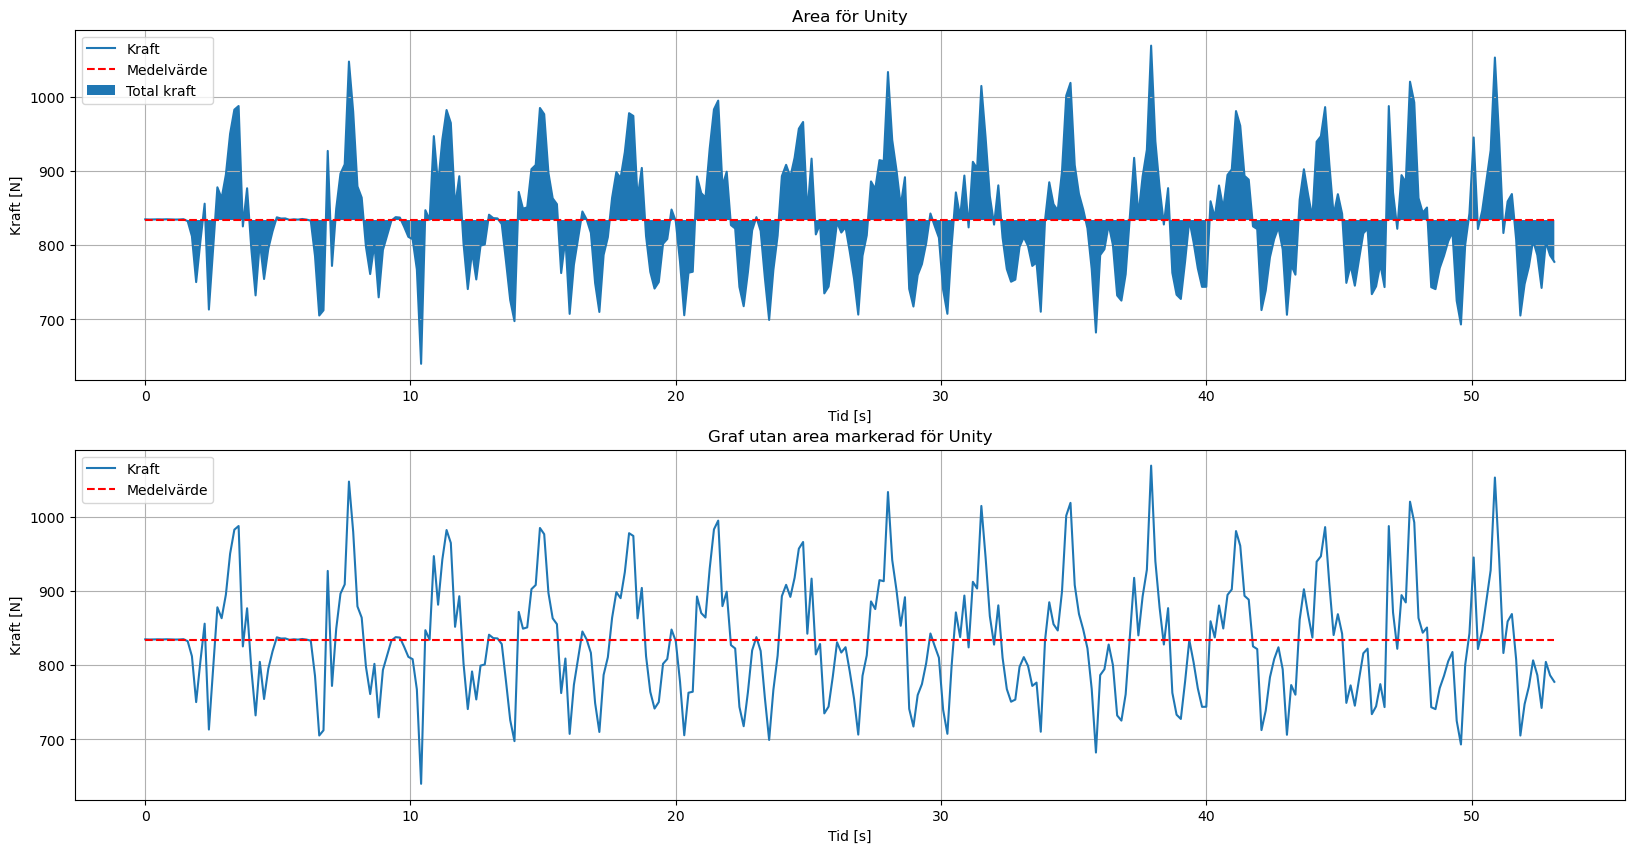

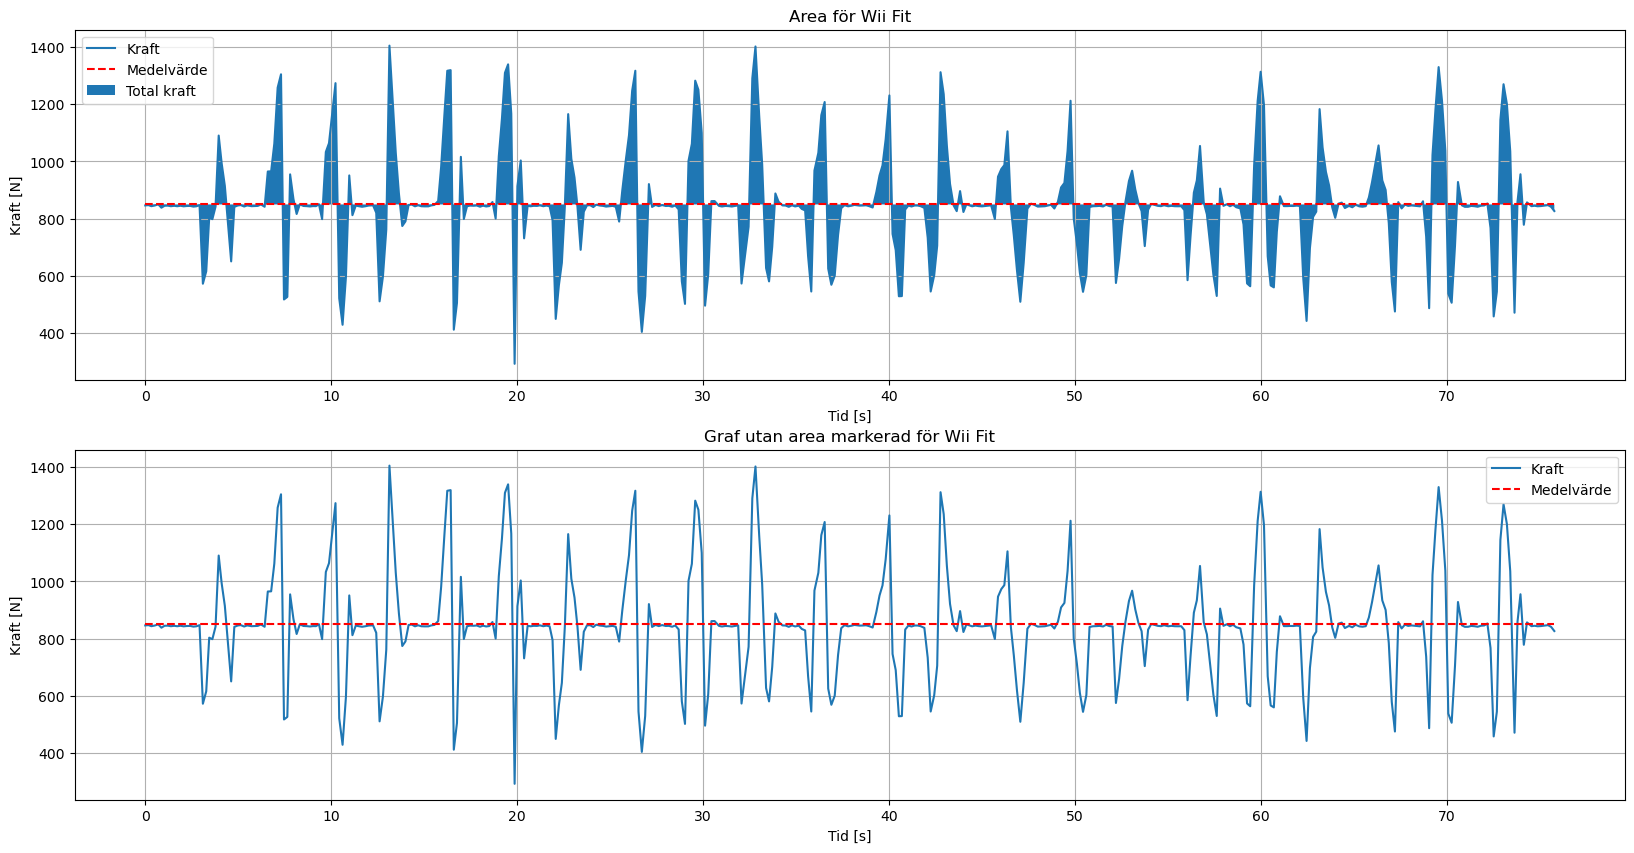

In [174]:
def showSurface(dataframe, title):
    snippetOfGraph = dataframe[0:int(dataframe.shape[0]/2)]
    horizontalLine = np.arange(0, snippetOfGraph.shape[0])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft")
    ax1.legend()
    ax1.grid()
    ax1.set_title(f"Area för {title}")

    ax2.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax2.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax2.set_xlabel("Tid [s]")
    ax2.set_ylabel("Kraft [N]")
    ax2.legend()
    ax2.grid()
    ax2.set_title(f"Graf utan area markerad för {title}")
    plt.show()

showSurface(unityDF, "Unity")
showSurface(wiiFitDF, "Wii Fit")

Marked area: 1.0


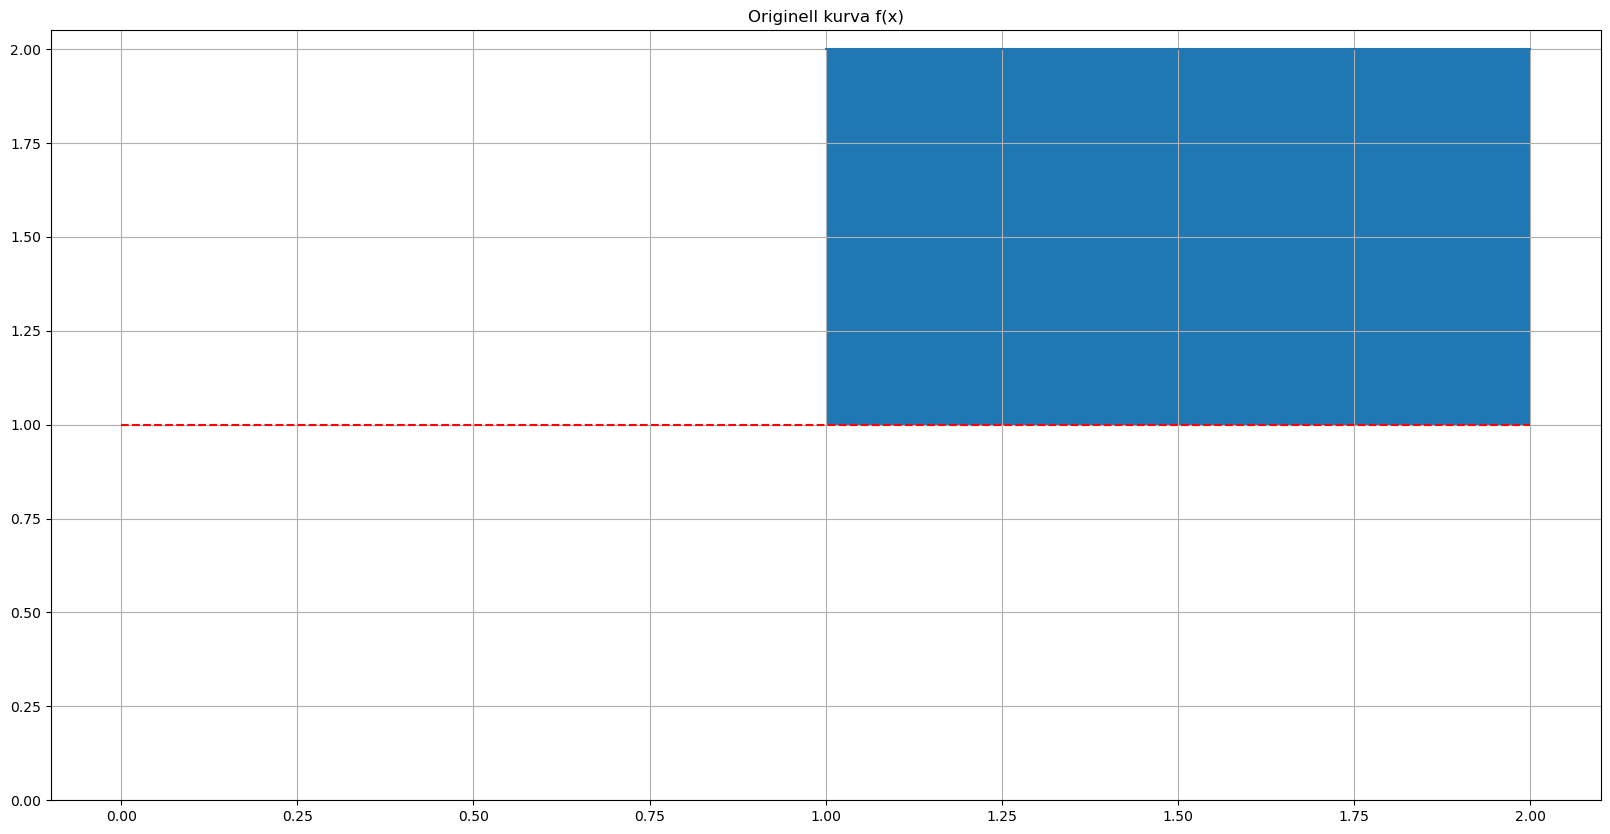

In [138]:
###############################################################
## Gammal kod
###############################################################


x_line= [1,2]
y_line= [2,2]

horizontalLine_x=[1,2]
horizontalLine_y=[1,1]


fig, axs = plt.subplots(1, figsize=(20,10))

axs.plot(x_line,y_line)
axs.grid()
axs.hlines(y=1,xmin=0, xmax=2, linestyles='dashed', colors='red')
axs.fill_between(x_line,y_line, 1)
axs.set_title("Originell kurva f(x)")
axs.set_ylim(bottom=0)


integralAbove = cumulative_trapezoid(y=y_line, x=x_line, initial=0)
integralBelow = cumulative_trapezoid(y=horizontalLine_y, x=horizontalLine_x, initial=0)

areabetween = integralAbove[len(integralAbove)-1] - integralBelow[len(integralBelow)-1]
print(f"Marked area: {areabetween}")

integralFirst = cumulative_trapezoid([1,1],[0,1],initial=0)
integralSecond = cumulative_trapezoid([1,1],[1,2],initial=0)

plt.show()




Kraftkurva: F(x) 			 Median G(x) 			 Diff 			 Positiv Diff
96.0 [N] 		 - 		 96.0 [N] 		 = 	 -0.0 [N] 		 (-)0.004 [N]
668.6 [N] 		 - 		 668.5 [N] 		 = 	 0.1 [N]
218.7 [N] 		 - 		 218.7 [N] 		 = 	 -0.0 [N] 		 (-)0.02 [N]
141.4 [N] 		 - 		 141.3 [N] 		 = 	 0.0 [N]
571.2 [N] 		 - 		 592.3 [N] 		 = 	 -21.1 [N] 		 (-)2e+01 [N]
77.1 [N] 		 - 		 76.1 [N] 		 = 	 1.0 [N]
287.1 [N] 		 - 		 309.5 [N] 		 = 	 -22.4 [N] 		 (-)2e+01 [N]
950.2 [N] 		 - 		 864.7 [N] 		 = 	 85.4 [N]
31.9 [N] 		 - 		 32.0 [N] 		 = 	 -0.2 [N] 		 (-)0.2 [N]
182.3 [N] 		 - 		 177.8 [N] 		 = 	 4.5 [N]
798.2 [N] 		 - 		 845.6 [N] 		 = 	 -47.4 [N] 		 (-)5e+01 [N]
385.4 [N] 		 - 		 384.7 [N] 		 = 	 0.7 [N]
129.2 [N] 		 - 		 129.2 [N] 		 = 	 -0.0 [N] 		 (-)0.04 [N]
119.2 [N] 		 - 		 119.2 [N] 		 = 	 0.0 [N]
82.3 [N] 		 - 		 82.3 [N] 		 = 	 -0.0 [N] 		 (-)0.008 [N]
209.0 [N] 		 - 		 208.9 [N] 		 = 	 0.1 [N]
Sum:												182.95936272920005 [N]


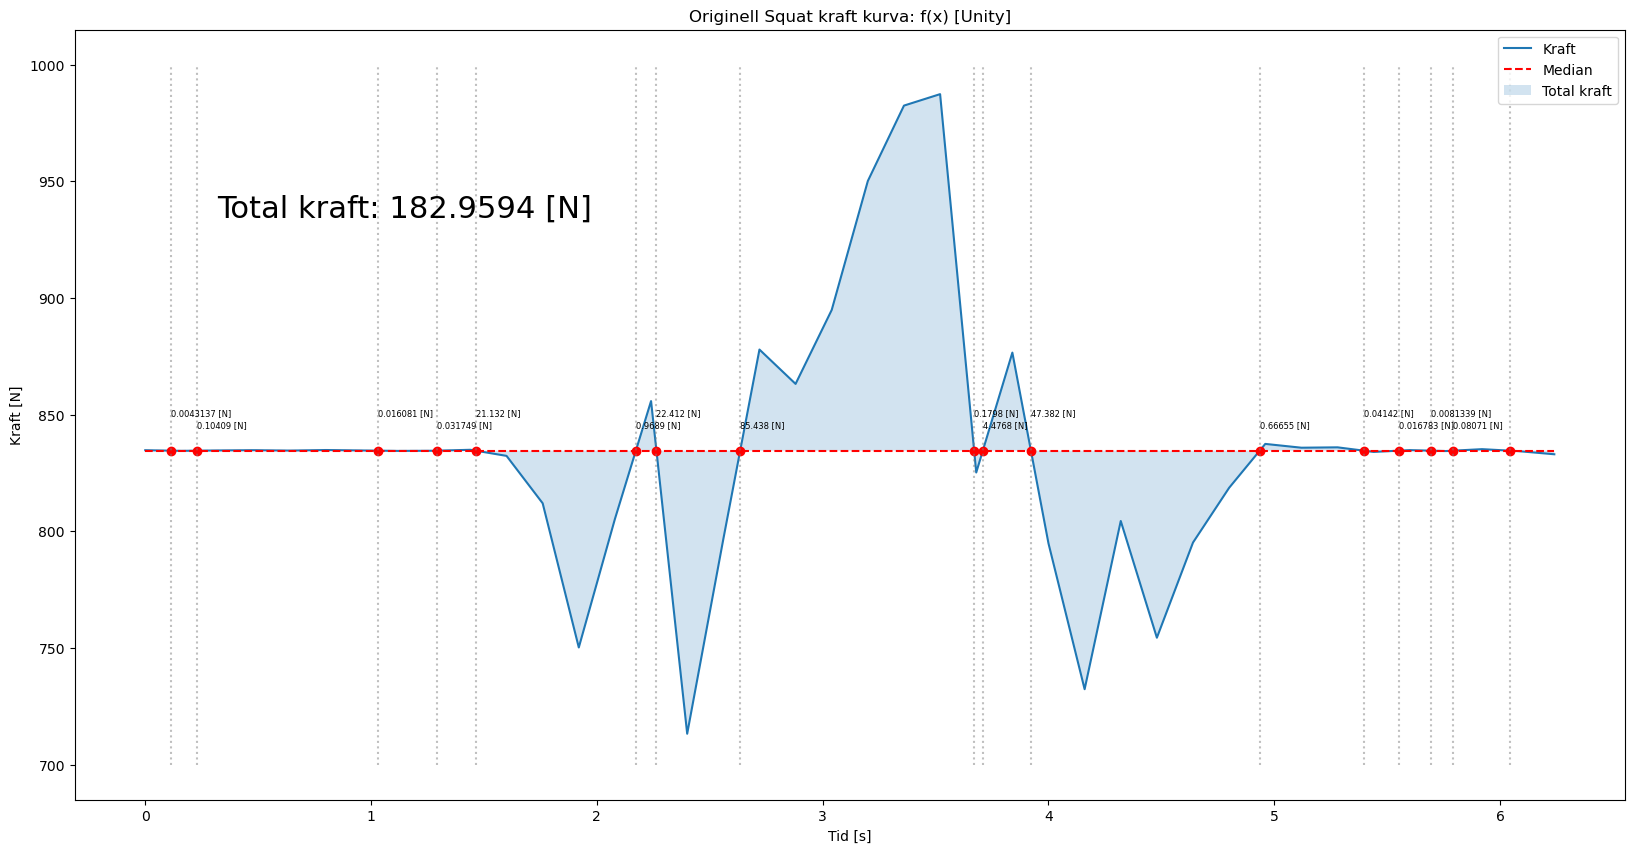

Kraftkurva: F(x) 			 Median G(x) 			 Diff 			 Positiv Diff
40.6 [N] 		 - 		 40.6 [N] 		 = 	 -0.0 [N] 		 (-)0.009 [N]
359.2 [N] 		 - 		 358.1 [N] 		 = 	 1.1 [N]
191.0 [N] 		 - 		 191.7 [N] 		 = 	 -0.6 [N] 		 (-)0.6 [N]
274.2 [N] 		 - 		 273.9 [N] 		 = 	 0.3 [N]
90.1 [N] 		 - 		 90.1 [N] 		 = 	 -0.0 [N] 		 (-)0.03 [N]
178.7 [N] 		 - 		 178.6 [N] 		 = 	 0.1 [N]
107.6 [N] 		 - 		 107.6 [N] 		 = 	 -0.0 [N] 		 (-)0.04 [N]
172.6 [N] 		 - 		 172.5 [N] 		 = 	 0.1 [N]
178.0 [N] 		 - 		 178.1 [N] 		 = 	 -0.1 [N] 		 (-)0.09 [N]
216.3 [N] 		 - 		 216.3 [N] 		 = 	 0.1 [N]
276.9 [N] 		 - 		 277.2 [N] 		 = 	 -0.4 [N] 		 (-)0.4 [N]
116.7 [N] 		 - 		 116.5 [N] 		 = 	 0.2 [N]
623.0 [N] 		 - 		 725.1 [N] 		 = 	 -102.1 [N] 		 (-)1e+02 [N]
572.2 [N] 		 - 		 497.7 [N] 		 = 	 74.4 [N]
402.8 [N] 		 - 		 443.7 [N] 		 = 	 -40.9 [N] 		 (-)4e+01 [N]
307.1 [N] 		 - 		 306.4 [N] 		 = 	 0.7 [N]
107.0 [N] 		 - 		 107.1 [N] 		 = 	 -0.1 [N] 		 (-)0.1 [N]
249.8 [N] 		 - 		 249.5 [N] 		 = 	 0.3 [N]
174.5 [N] 		 - 		 174.6

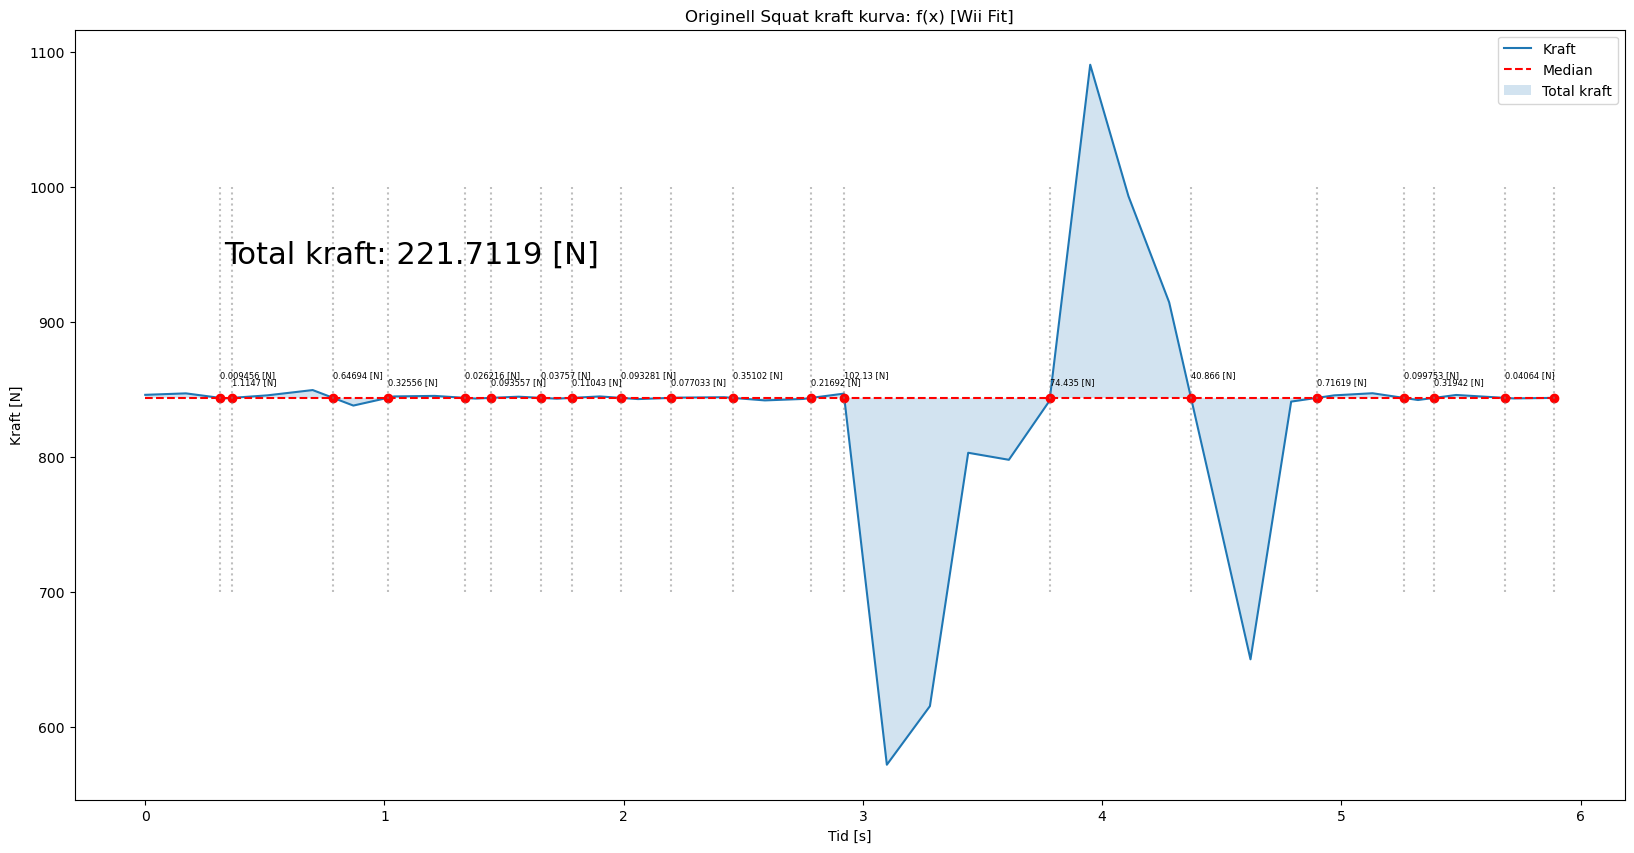

In [139]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMedian(dataframe, toRange, title):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Median")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        time.append(geom.y)
        force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    print("Kraftkurva: F(x) \t\t\t Median G(x) \t\t\t Diff \t\t\t Positiv Diff")

    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid            
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)
        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        
        if(diff < 0):
            print(f"{sliceIntegral1[len(sliceIntegral1) - 1]:.1f} [N] \t\t - \t\t {sliceIntegral2[len(sliceIntegral2) - 1]:.1f} [N] \t\t = \t {diff:.1f} [N] \t\t (-){diff*-1:.1} [N]")
        else:
            print(f"{sliceIntegral1[len(sliceIntegral1) - 1]:.1f} [N] \t\t - \t\t {sliceIntegral2[len(sliceIntegral2) - 1]:.1f} [N] \t\t = \t {diff:.1f} [N]")
        
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    print(f"Sum:\t\t\t\t\t\t\t\t\t\t\t\t{sumForce} [N]")
    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].median() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()
    

getAndShowSurfaceOfDFWithMedian(unityDF, 40, "Unity")
getAndShowSurfaceOfDFWithMedian(wiiFitDF, 35, "Wii Fit")



False


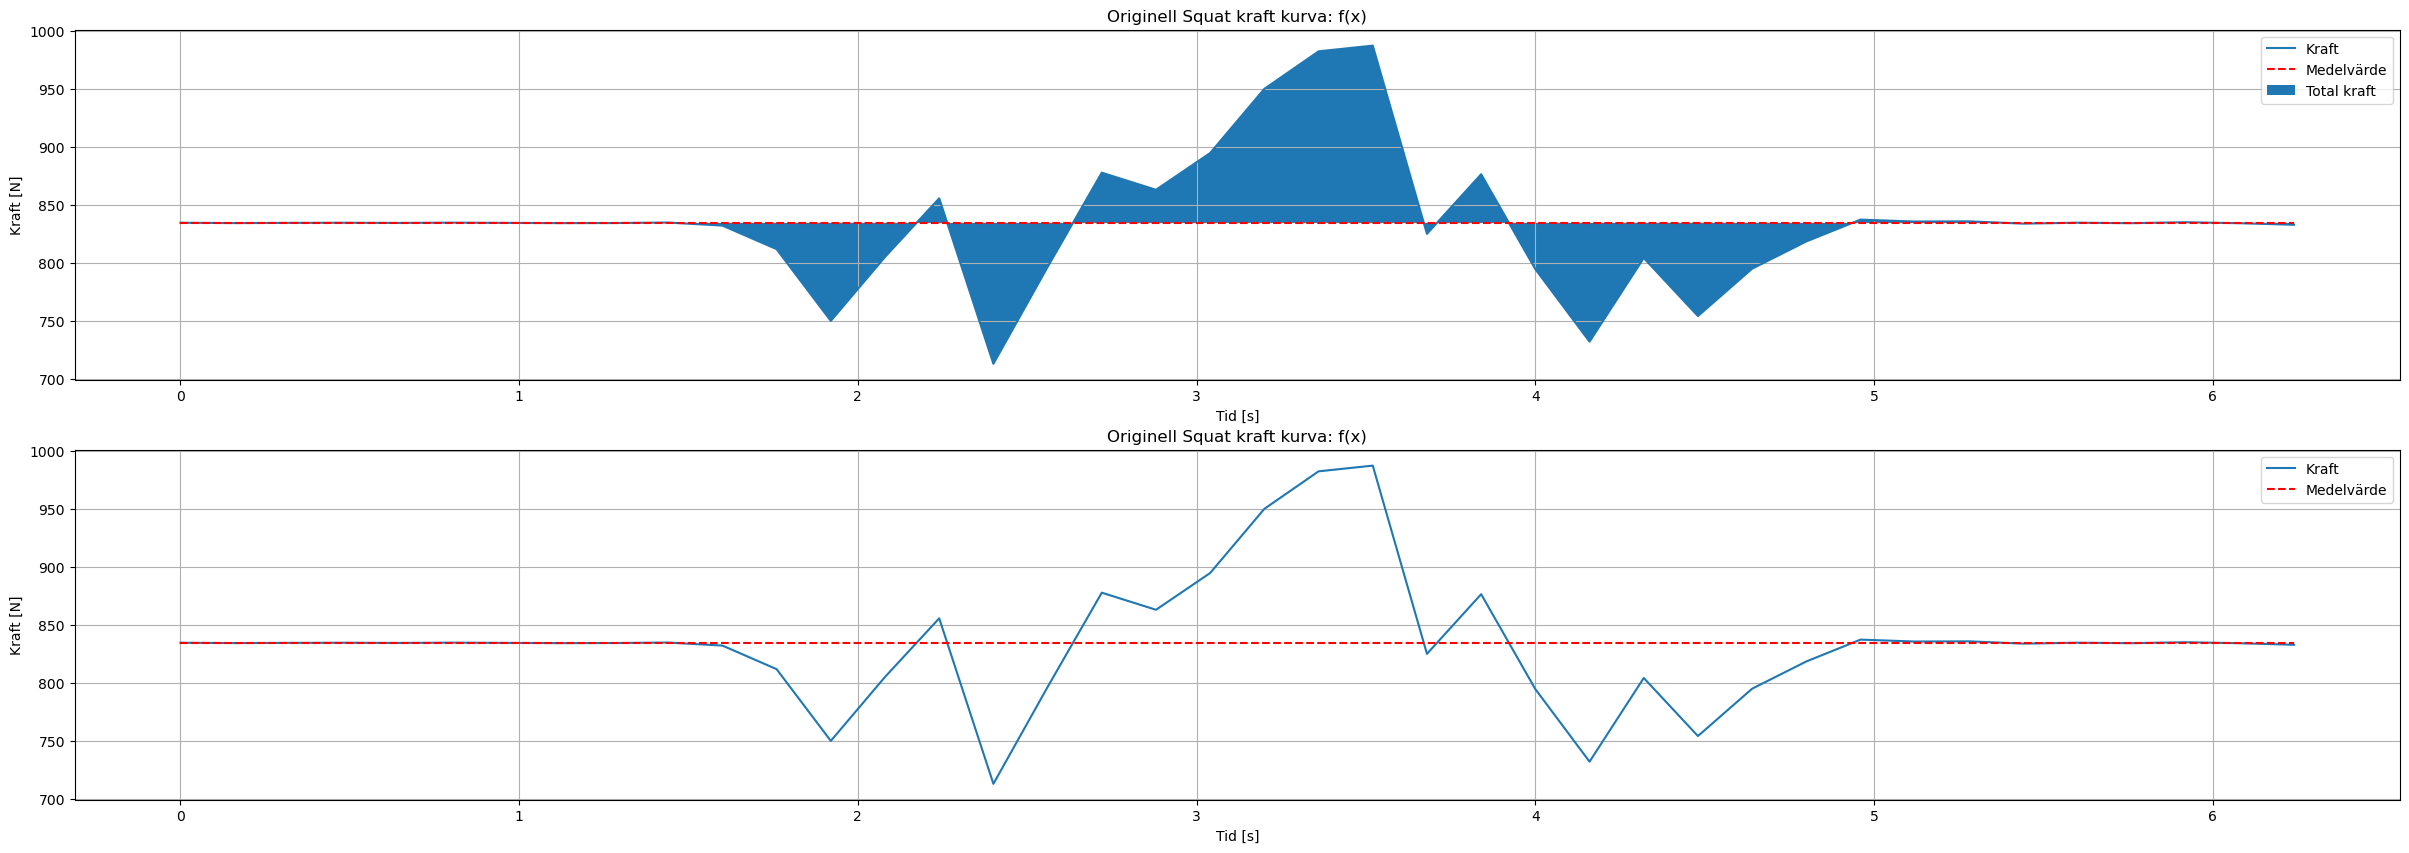

In [152]:
###############################################################
## Gammal kod
###############################################################



snippetOfGraph = unityDF[0:40]
horizontalLine = np.arange(0, snippetOfGraph.shape[0])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,10))

ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
ax1.set_xlabel("Tid [s]")
ax1.set_ylabel("Kraft [N]")
ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft")
ax1.legend()
ax1.set_title("Originell Squat kraft kurva: f(x)")
ax1.grid()

ax2.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
ax2.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
ax2.set_xlabel("Tid [s]")
ax2.set_ylabel("Kraft [N]")
ax2.legend()
ax2.grid()
ax2.set_title("Originell Squat kraft kurva: f(x)")

i = 0
mean = snippetOfGraph['force'].mean()
while(i < snippetOfGraph.shape[0]):
    if(snippetOfGraph['force'][i] == mean):
        ax2.plot(snippetOfGraph['time'][i],snippetOfGraph['force'][i], marker="X")
    i = i + 1
print(snippetOfGraph['force'][0]==mean)
y_filler=np.full((snippetOfGraph.shape[0]),snippetOfGraph['force'].mean())
integralOfSnippet = cumulative_trapezoid(y_filler,snippetOfGraph['force'],initial=0)

##Hitta indices och beräkna area därimellan
##https://stackoverflow.com/questions/28766692/how-to-find-the-intersection-of-two-graphs


#print(integralOfSnippet)
#ax3.plot(snippetOfGraph['time'], integralOfSnippet)
#ax3.grid()
#ax3.set_title("Integral av f(x): F(x)")

plt.show()

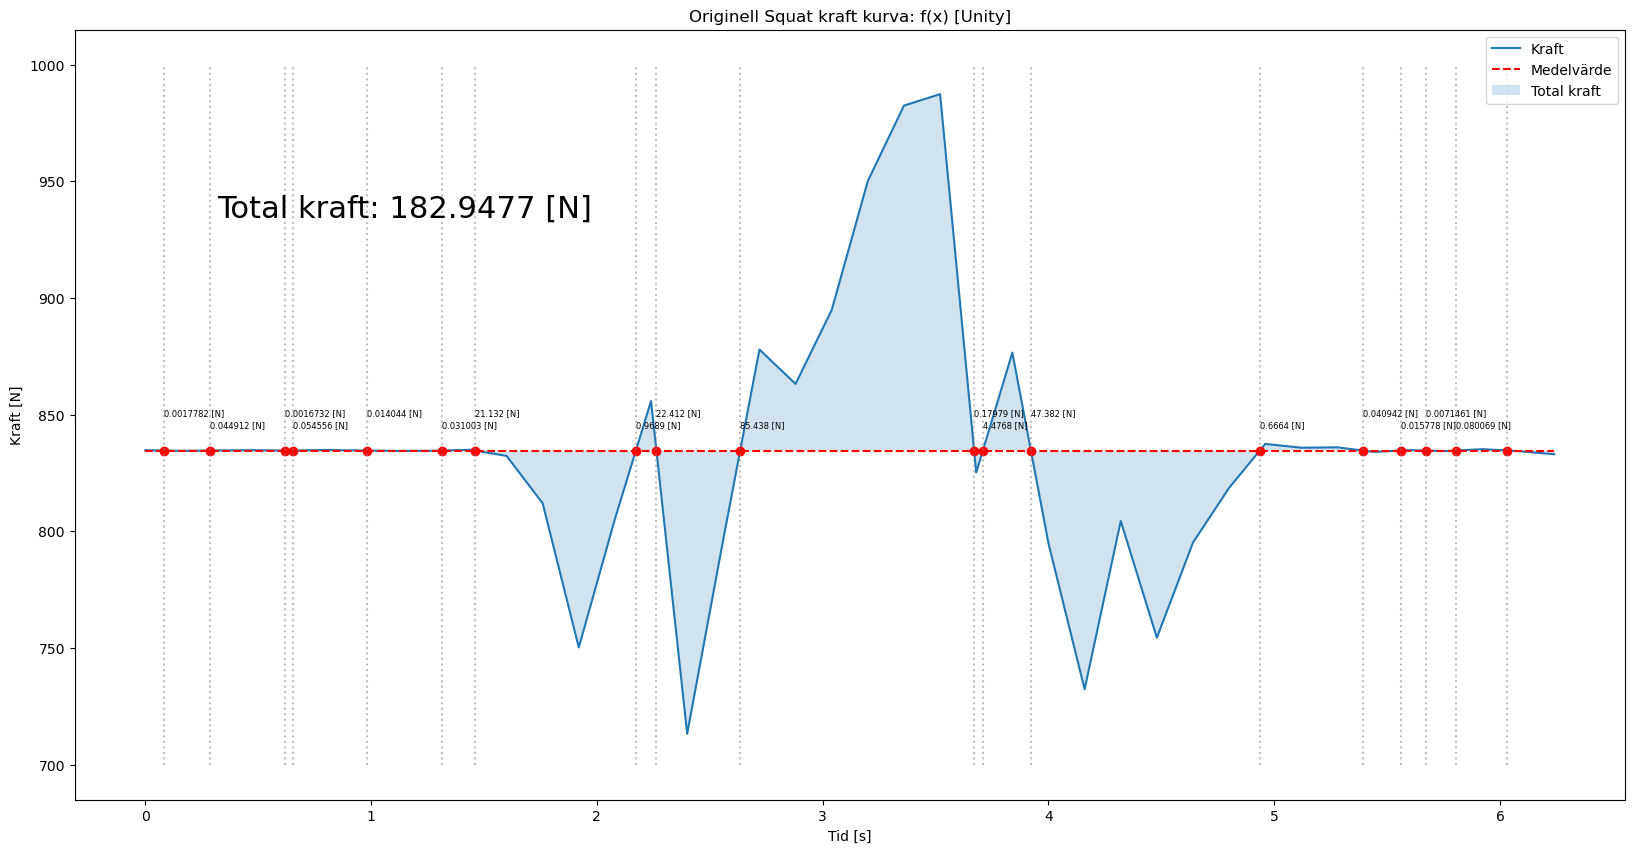

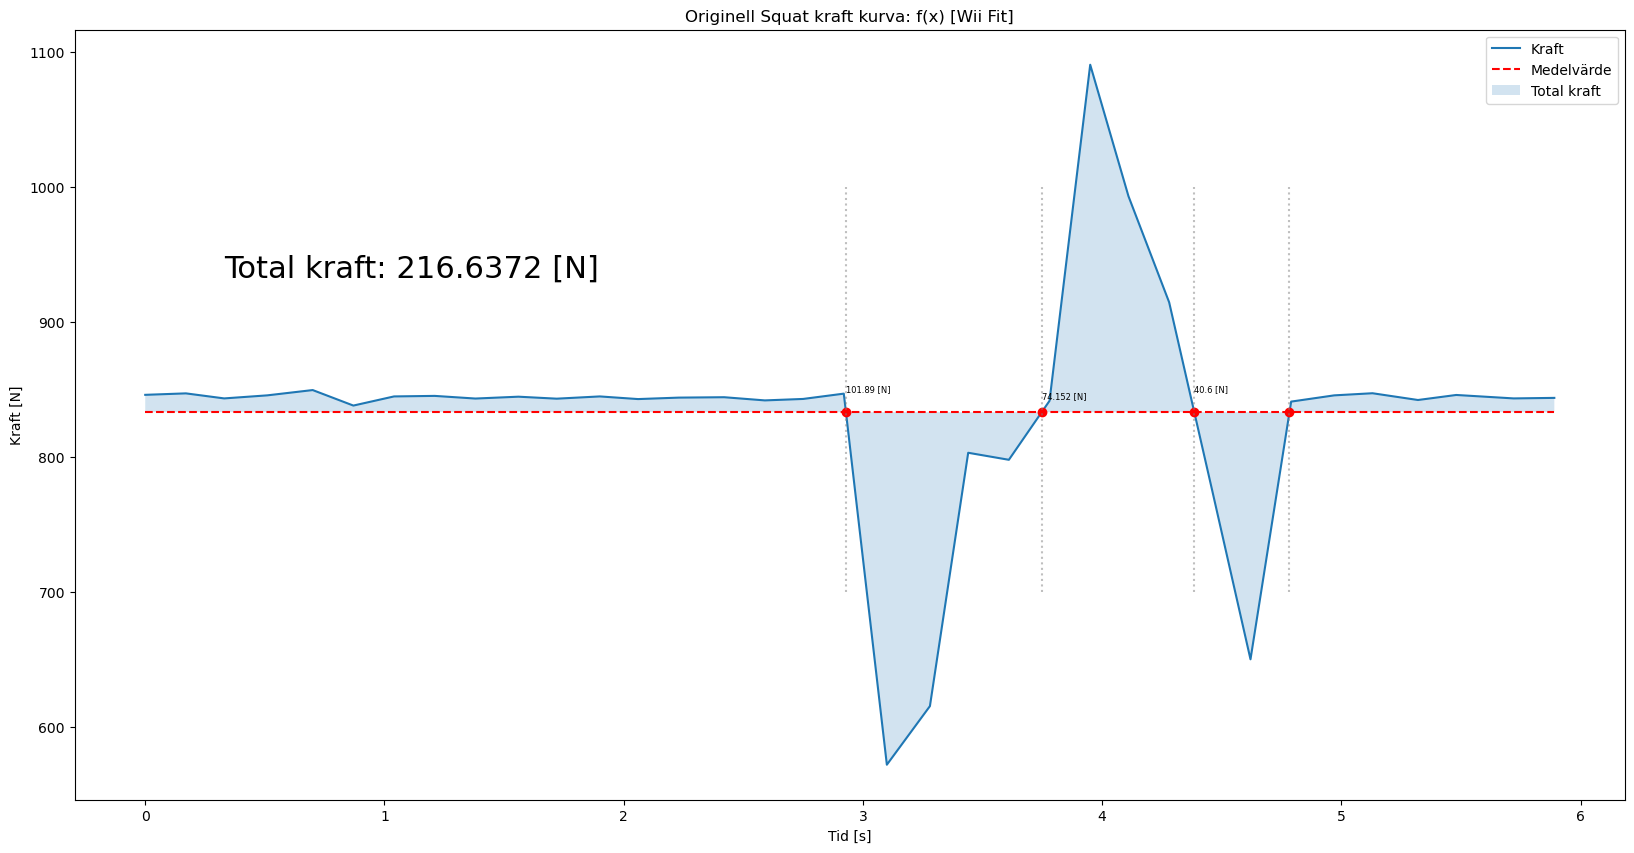

In [144]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMean(dataframe, toRange, title):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    meanArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].mean())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((meanArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        time.append(geom.y)
        force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].mean() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].mean() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

getAndShowSurfaceOfDFWithMean(unityDF, 40, "Unity")
getAndShowSurfaceOfDFWithMean(wiiFitDF, 35, "Wii Fit")



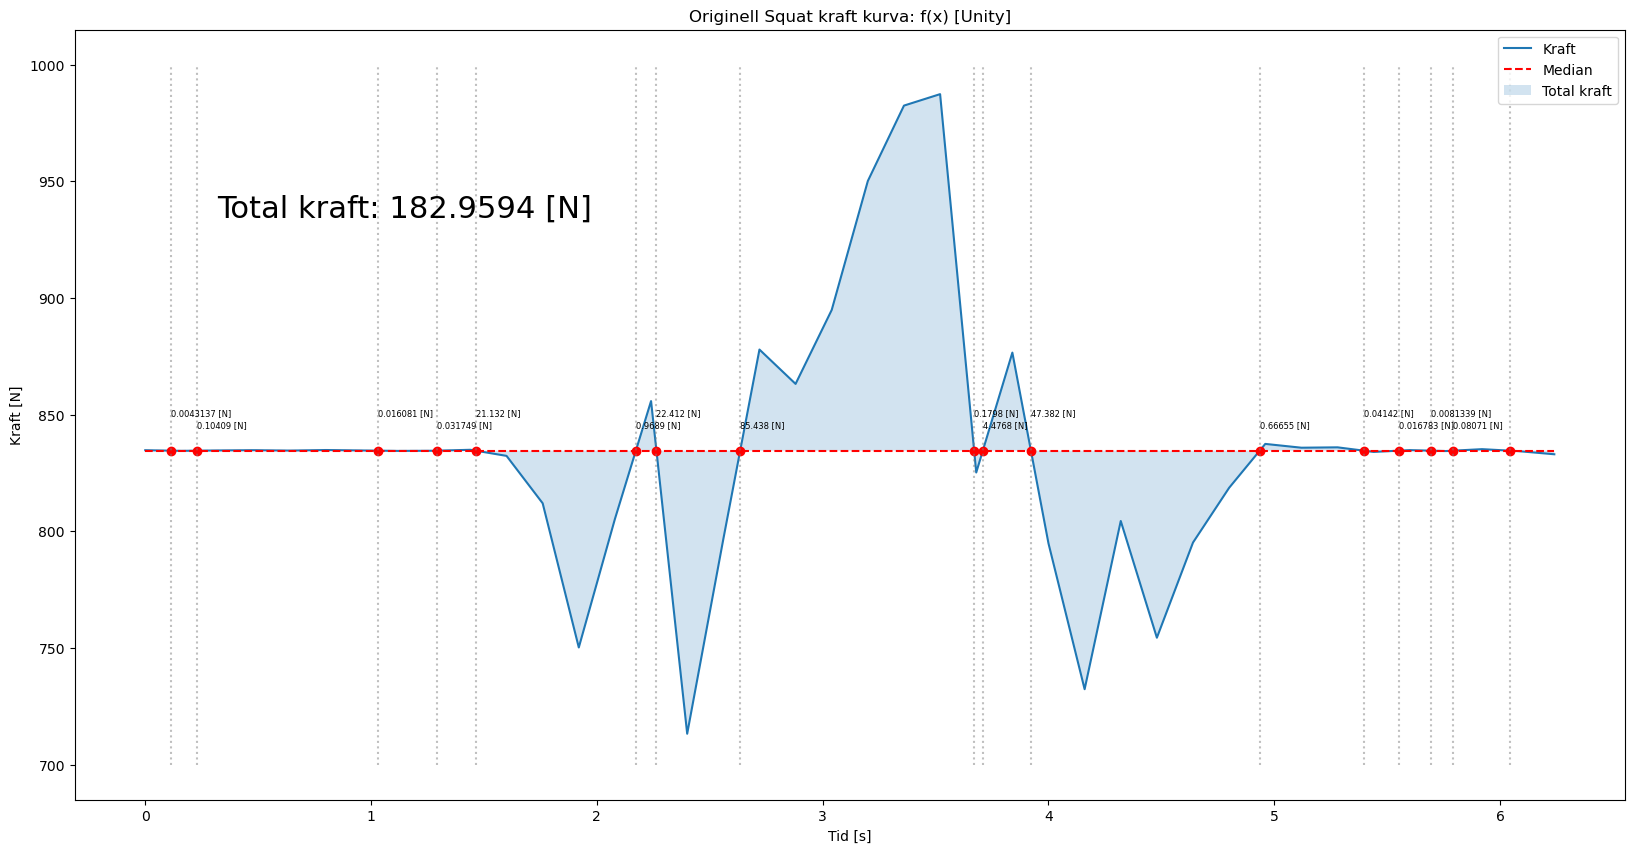

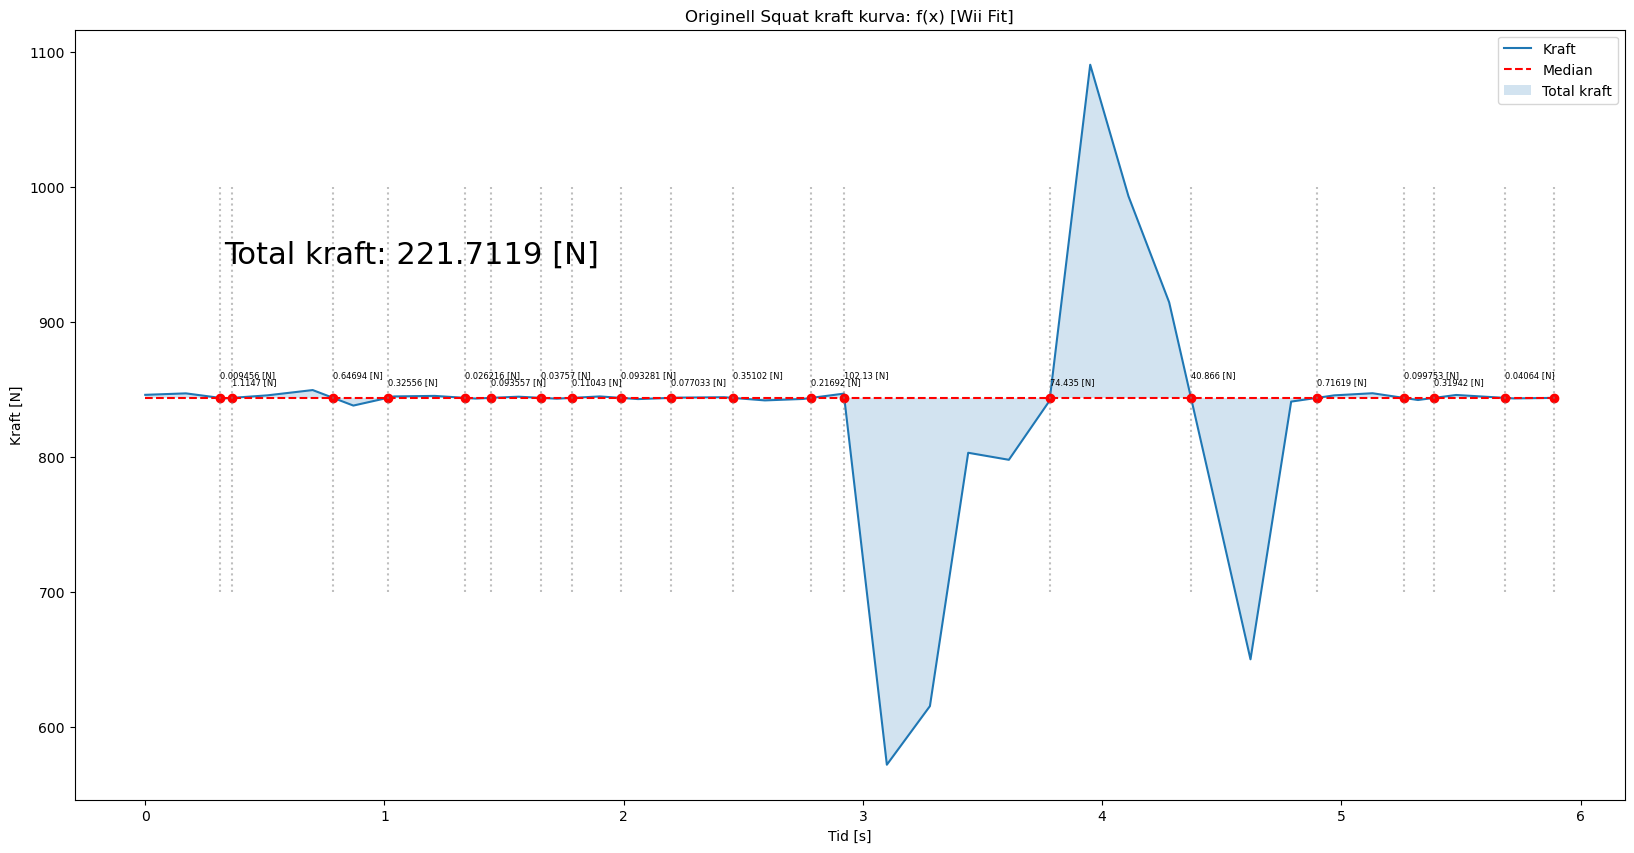

In [145]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMedian(dataframe, toRange, title):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Median")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        time.append(geom.y)
        force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].median() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

getAndShowSurfaceOfDFWithMedian(unityDF, 40, "Unity")
getAndShowSurfaceOfDFWithMedian(wiiFitDF, 35, "Wii Fit")



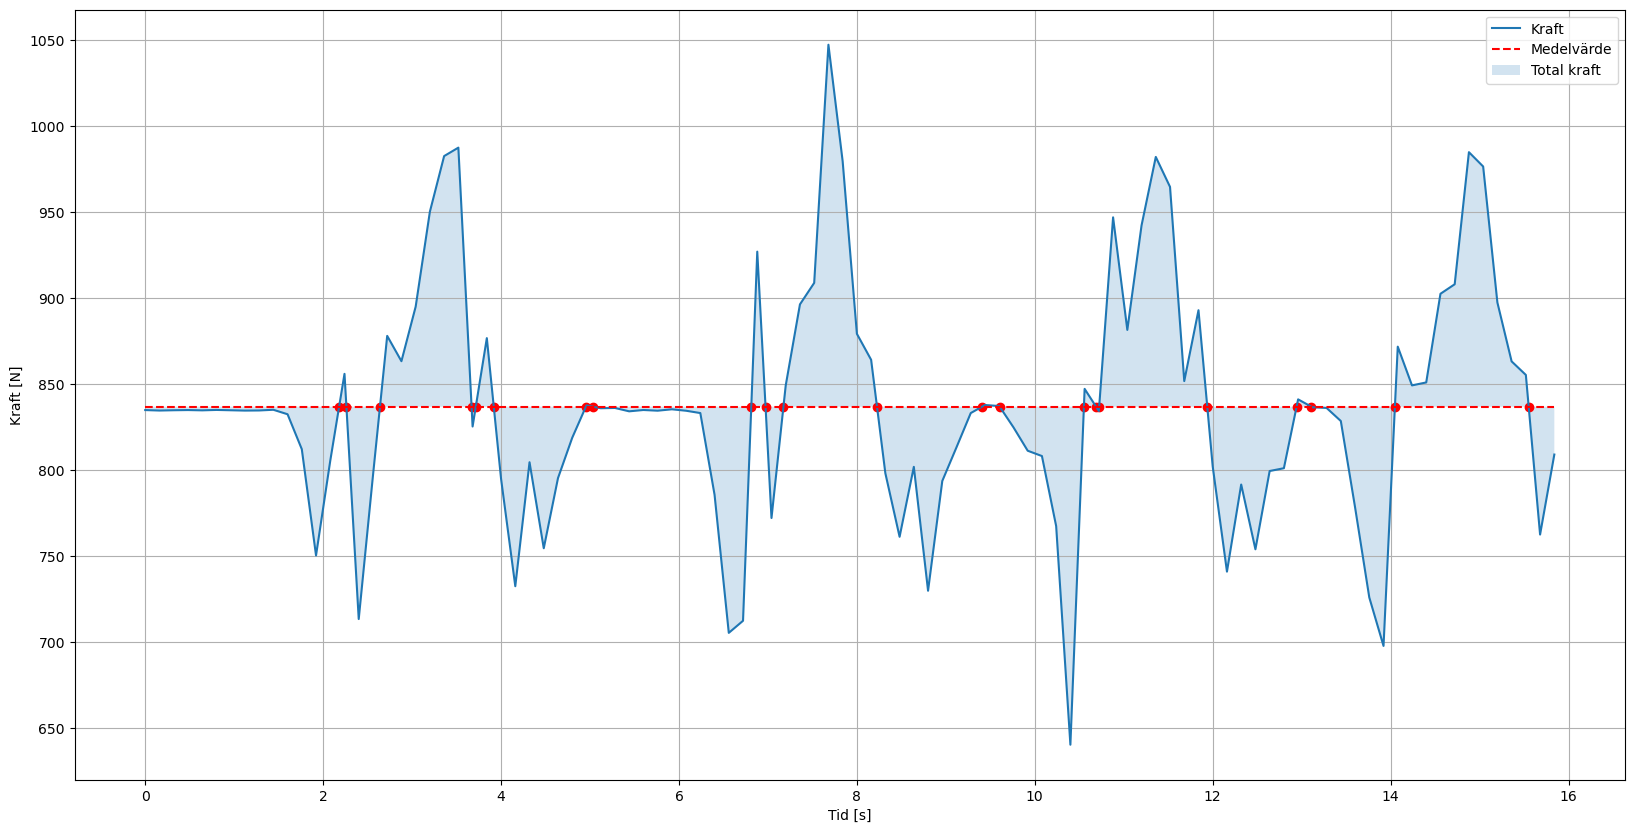

In [146]:

from shapely.geometry import LineString


snippetOfGraph = unityDF[0:100]

fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

meanArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].mean())

line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
line_2 = LineString(np.column_stack((meanArr,snippetOfGraph['time'])))

intersection = line_1.intersection(line_2)

#intersection.geoms
time = []
force = []
for geom in intersection.geoms:
    time.append(geom.y)
    force.append(geom.x)
 
ax1.plot(time, force, 'ro')


ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
ax1.set_xlabel("Tid [s]")
ax1.set_ylabel("Kraft [N]")
ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
ax1.legend()
ax1.grid()

plt.show()

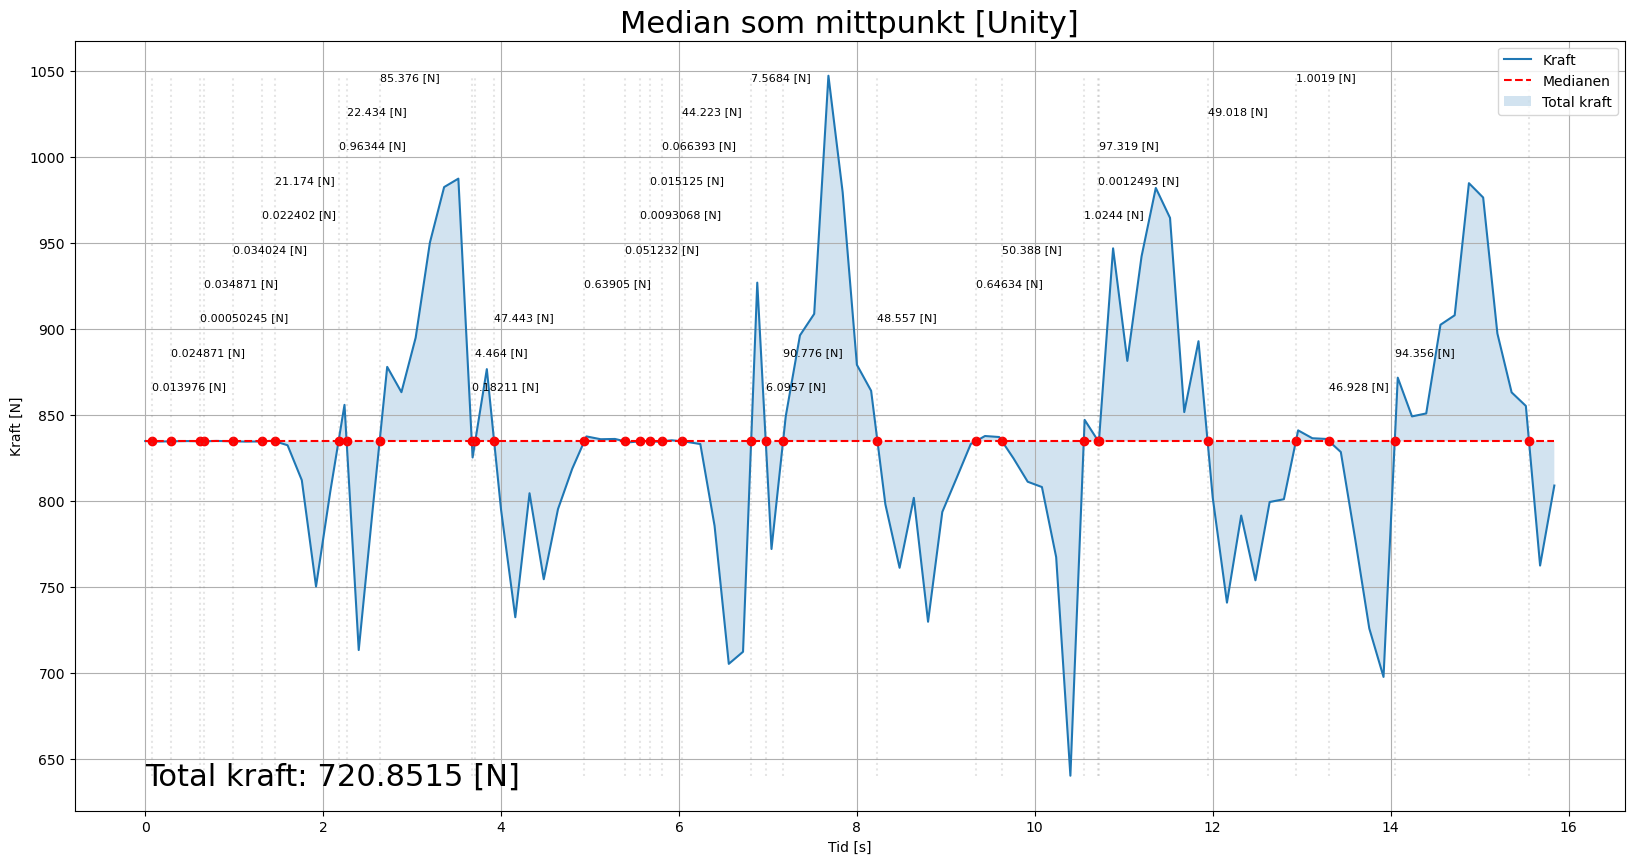

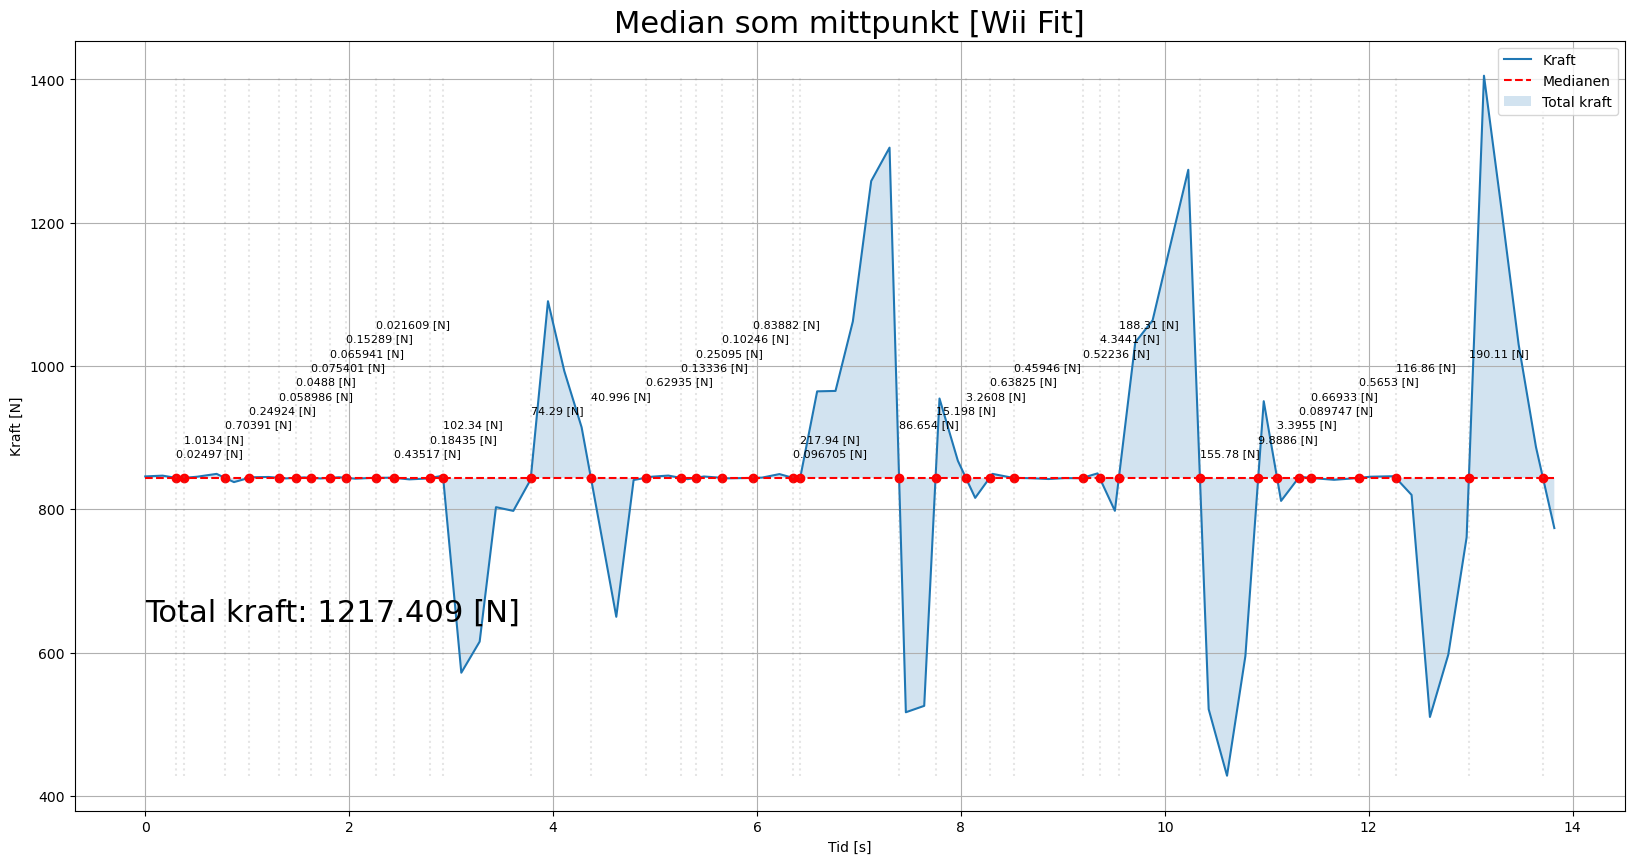

In [155]:


def integrateDFwithMedian(dataframe, title, rangeTo):
    snippetOfGraph = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())


    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    #intersection.geoms
    time = []
    force = []
    for geom in intersection.geoms:
        time.append(geom.y)
        force.append(geom.x)


    ## Bytte mittenlinjen till median istället för mean för att testa
    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medianen")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    ax1.grid()
    ax1.set_title(f"Median som mittpunkt [{title}]", fontsize=22)



    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=snippetOfGraph['force'].max(), ymin=snippetOfGraph['force'].min(), x=sortedTime, linestyles="dotted", colors="gray", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 20 * spacer, f'{diff:.5} [N]', fontsize = 8)
        sumForce = sumForce + diff
        
        if(spacer%10 == 0):
            spacer = 1
        else:
            spacer = spacer + 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(0, snippetOfGraph['force'].median() - 200, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

integrateDFwithMedian(unityDF, "Unity", 100)
integrateDFwithMedian(wiiFitDF, "Wii Fit", 80)


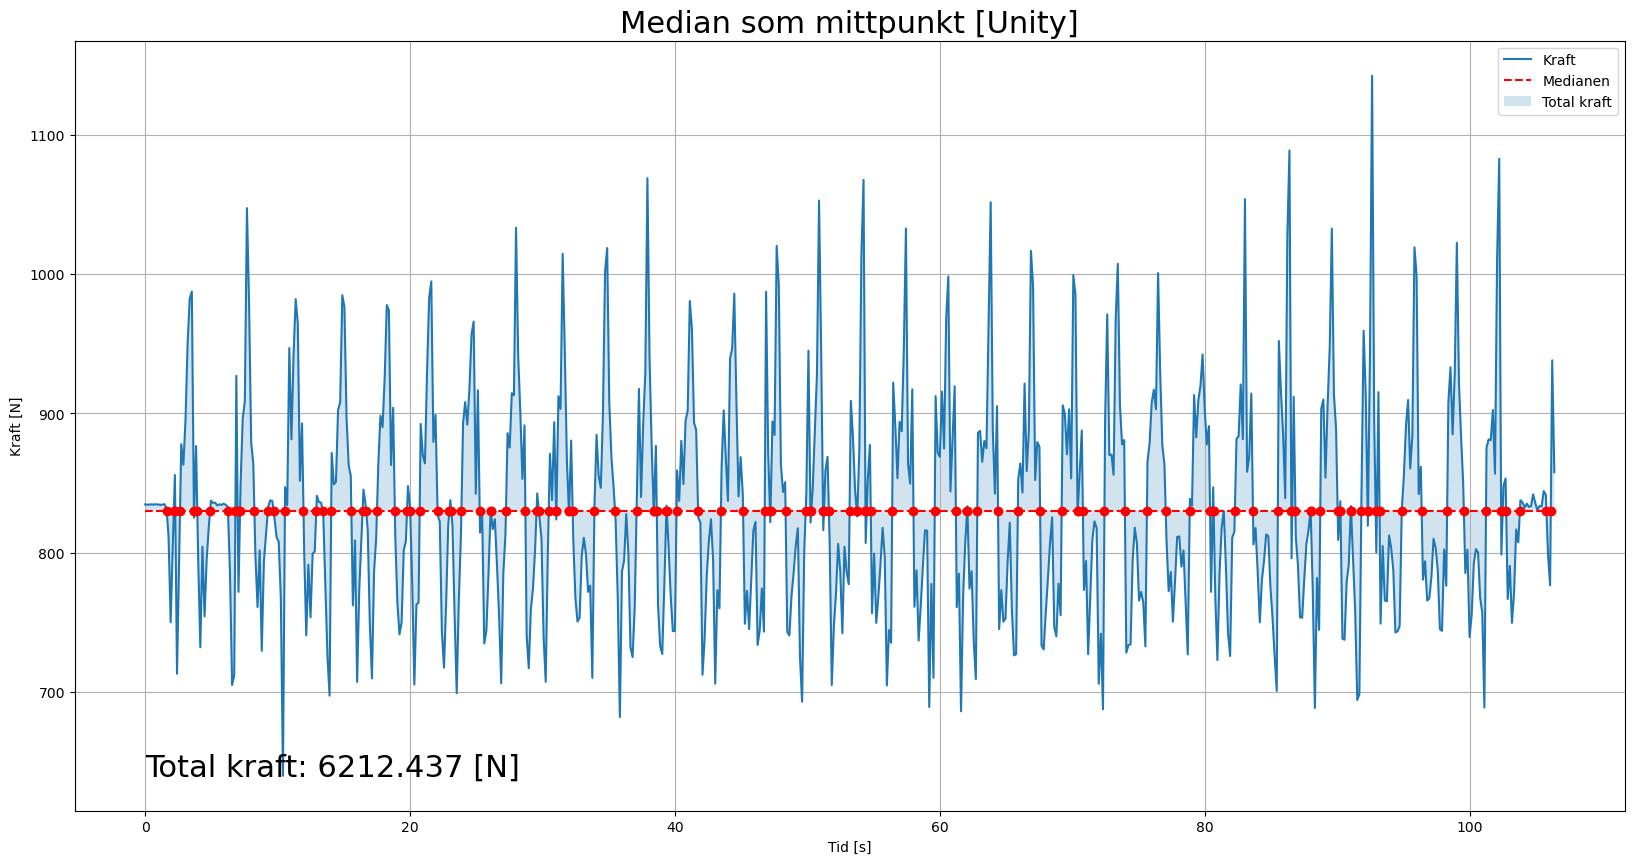

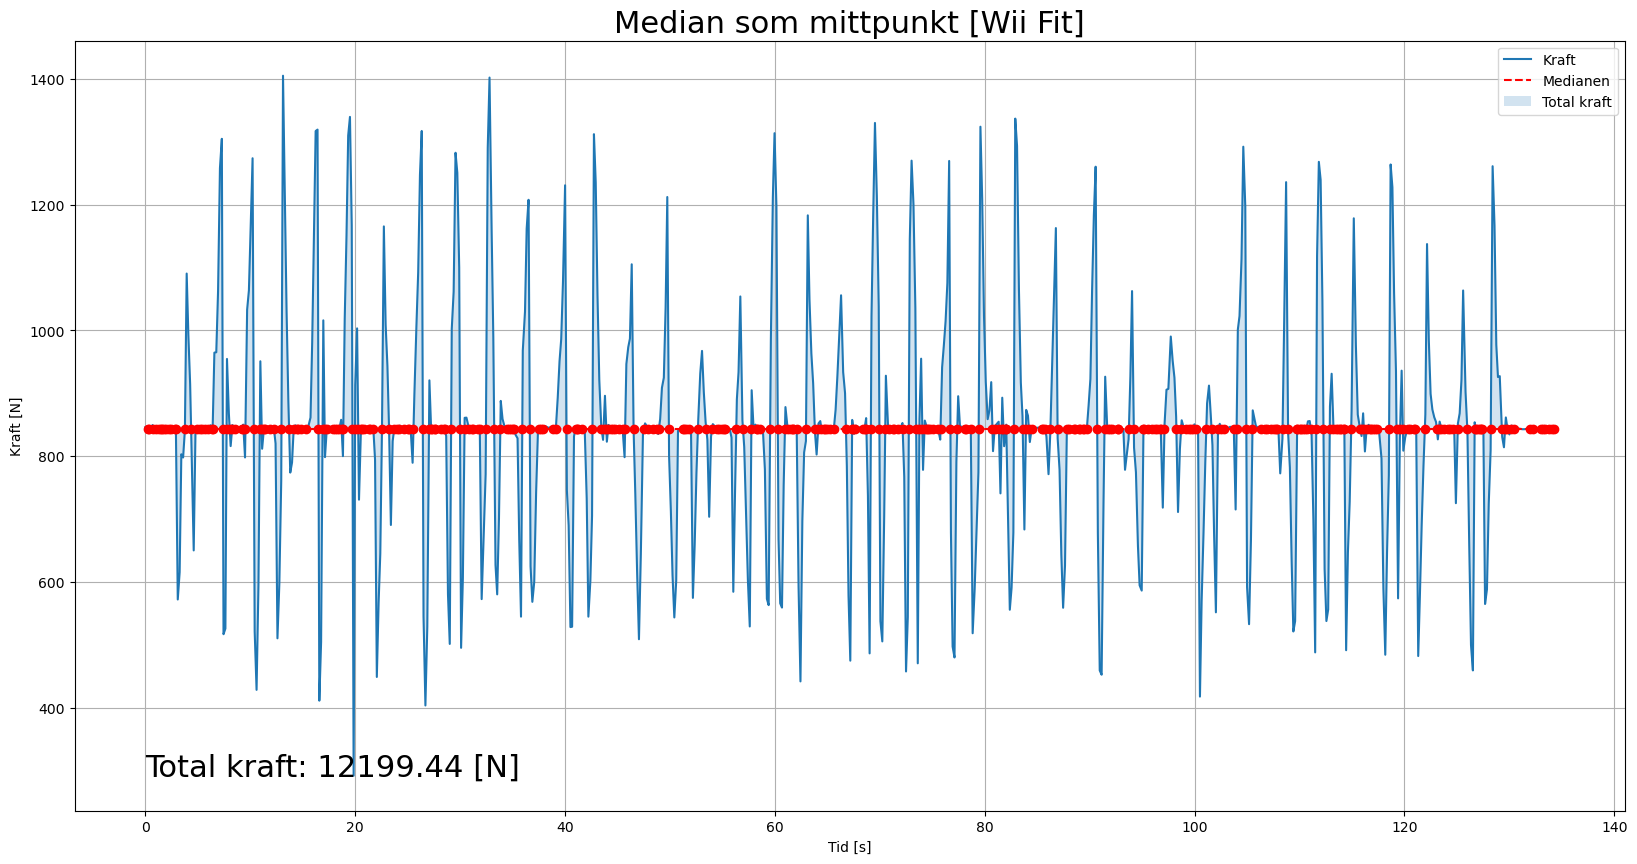

In [220]:


def integrateDFwithMedian(dataframe, title, rangeTo, showText, showLines):
    snippetOfGraph = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())


    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    #intersection.geoms
    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)


    ## Bytte mittenlinjen till median istället för mean för att testa
    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medianen")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    ax1.grid()
    ax1.set_title(f"Median som mittpunkt [{title}]", fontsize=22)



    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    if(showLines == True):
        ax1.vlines(ymax=snippetOfGraph['force'].max(), ymin=snippetOfGraph['force'].min(), x=sortedTime, linestyles="dotted", colors="gray", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        if(showText):
            ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 20 * spacer, f'{diff:.5} [N]', fontsize = 8)
        sumForce = sumForce + diff
        
        if(spacer%10 == 0):
            spacer = 1
        else:
            spacer = spacer + 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(0, snippetOfGraph['force'].min(), f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

integrateDFwithMedian(unityDF, "Unity", unityDF['time'].shape[0], False, False)
integrateDFwithMedian(wiiFitDF, "Wii Fit", 760, False, False)



## Lokal maximi och minipunkter för var benböjs beräkning.

För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.  
y = kx + m => k = Δy / Δx => k = y2- y1 / x2 - x1

[[Källa]](https://stackoverflow.com/questions/69000410/extract-and-plot-the-first-derivative-of-a-curve-in-python-without-knowing-its-f)

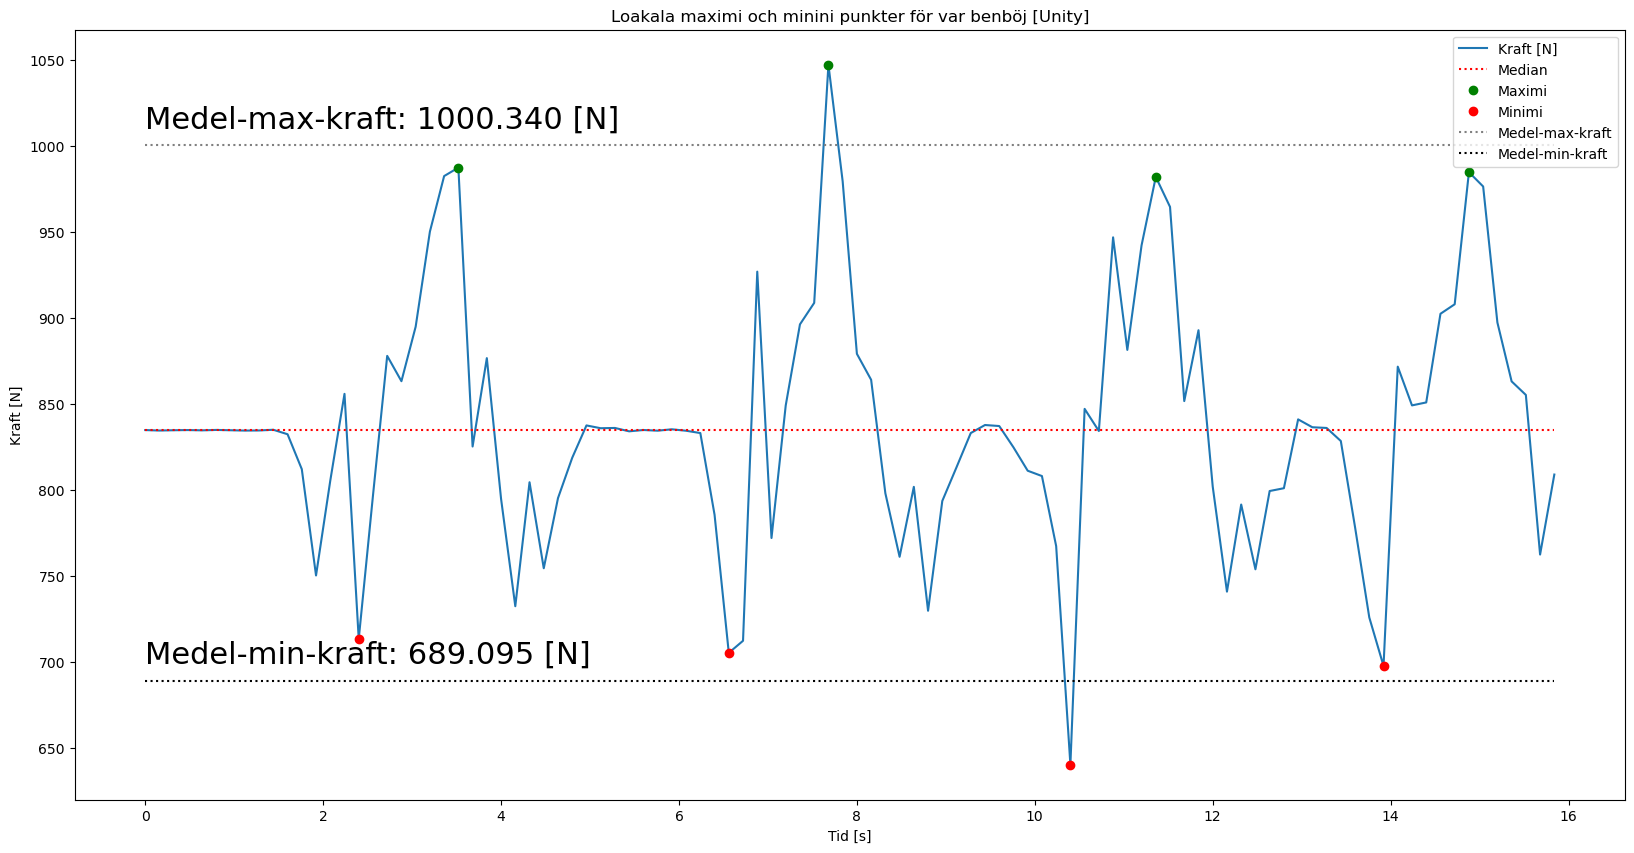

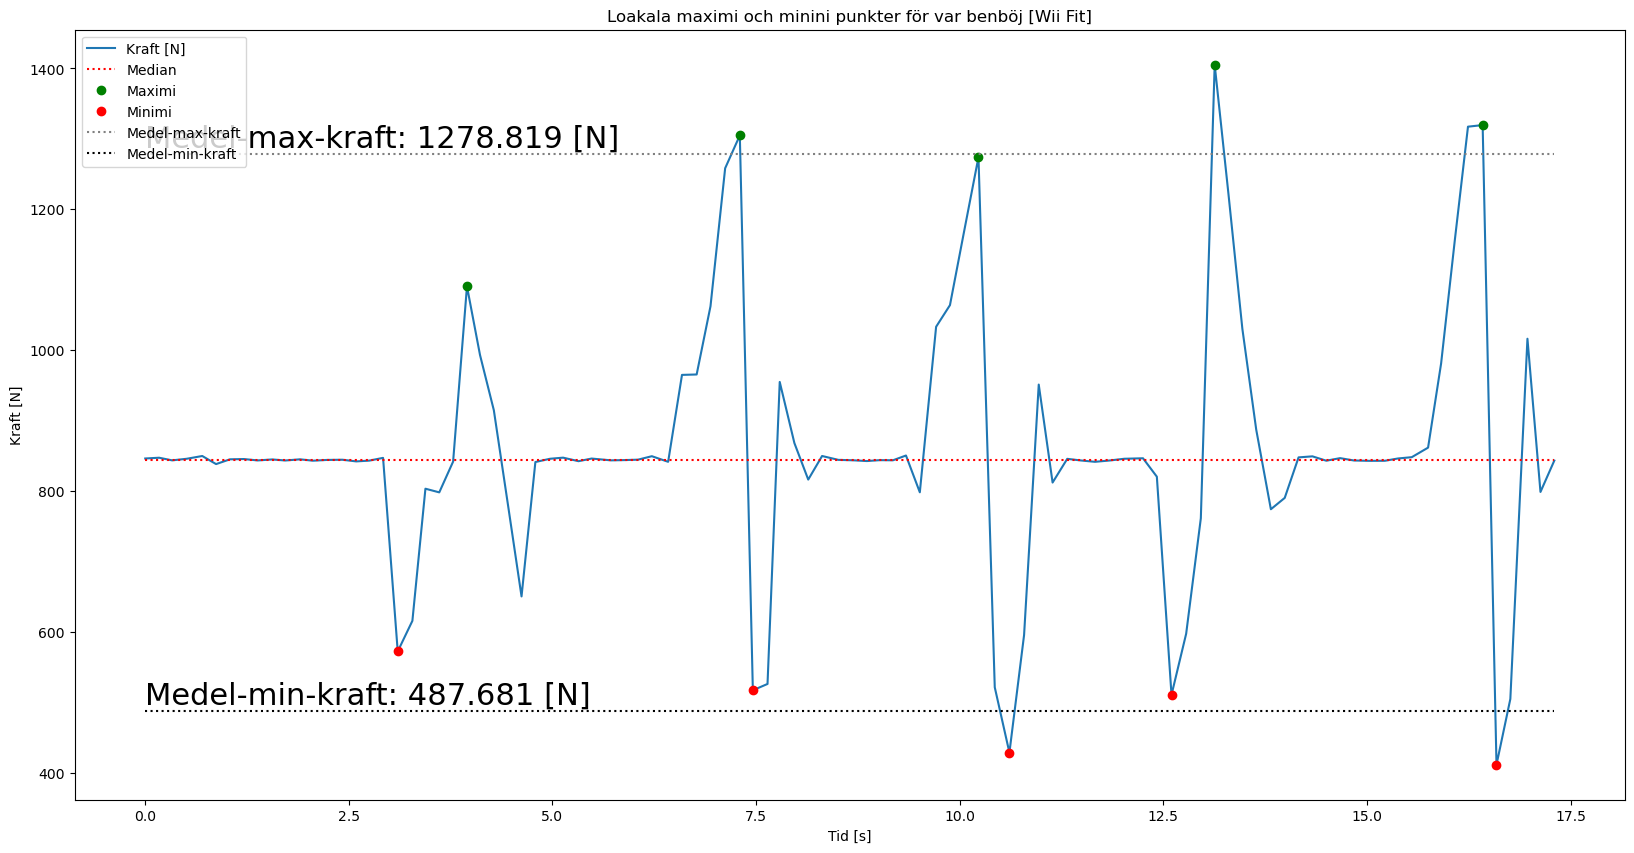

In [227]:
def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4


    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]

    ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")

    averageMaxForce = maximaForce.mean()
    averageMinForce = minimaForce.mean()

    ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()
    
    return minimaForce, maximaForce

minimaForceUnity, maximaForceUnity = showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=100, title="Unity", nrOfSquats=4)
minimaForceWiiFit, maxmiaForceWiiFit = showMaximaAndMinimaForDataframe(dataframe=wiiFitDF, rangeTo=100, title="Wii Fit", nrOfSquats=5)



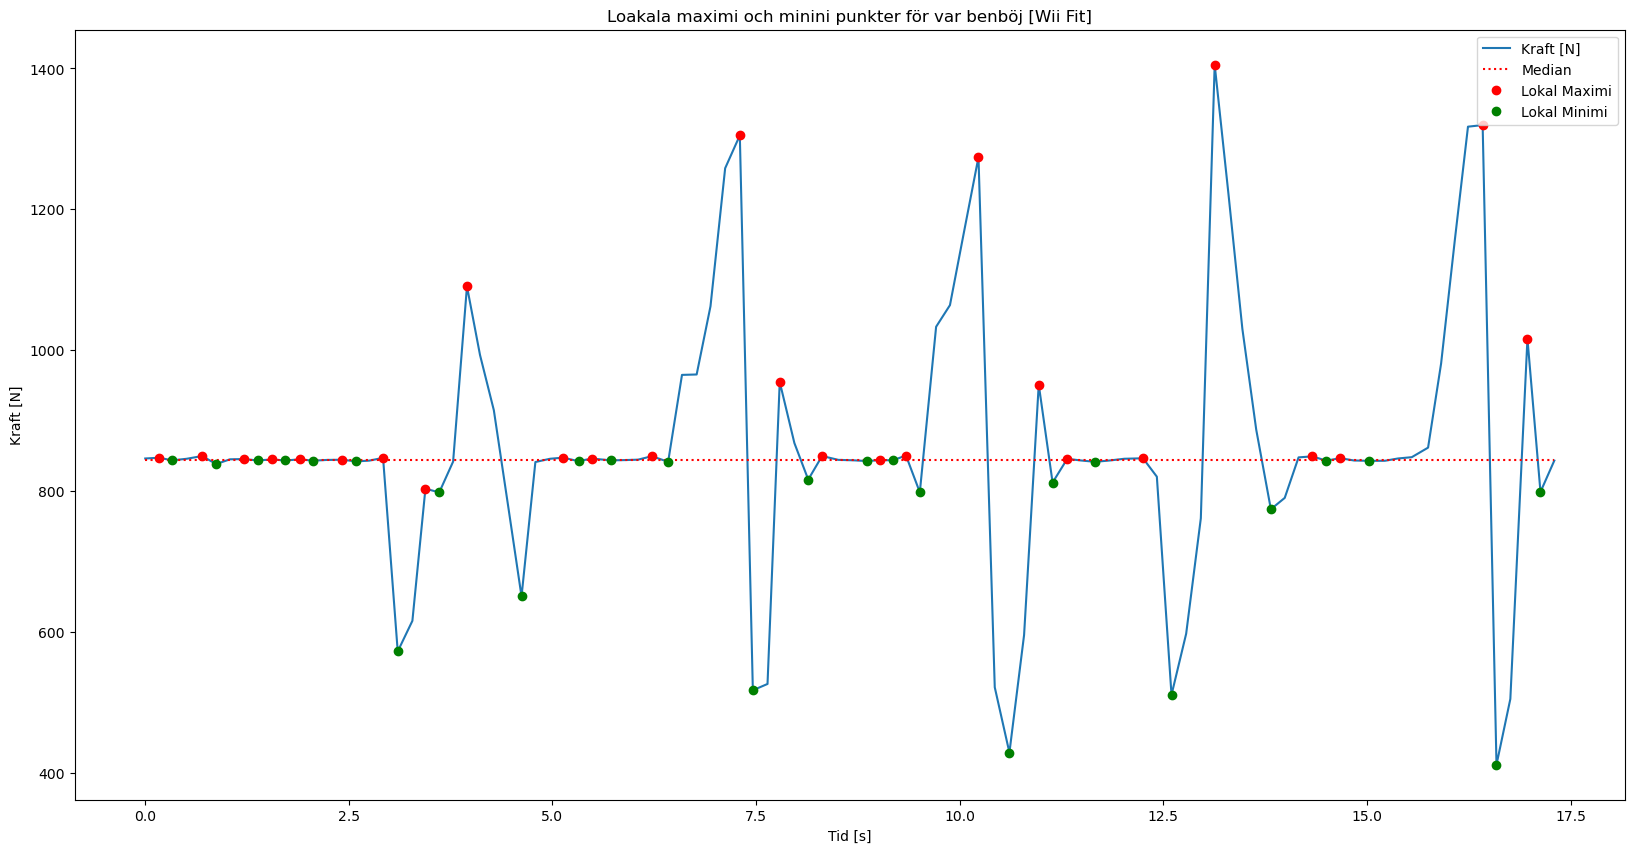

In [228]:
def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4

    ax1.plot(localMaximaTime,localMaximaForce, "ro", label="Lokal Maximi")
    ax1.plot(localMinimaTime,localMinimaForce, "go", label="Lokal Minimi")

    data0 = {
        "time":localMaximaTime,
        "force":localMaximaForce,
        "maxima":True
    }
    data1 = {
        "time":localMinimaTime,
        "force":localMinimaForce,
        "maxima":False
    }
    
    df0 = pd.DataFrame(data0)
    df1 = pd.DataFrame(data1)
    dfFull = pd.concat([df0,df1])
    dfFull.sort_values(by='time')
    
    minimaForce0 = []
    minimaTime0 = []
    
    #for row in dfFull:
    # Titta om man är vid "near" ett visst värde.
    # Kolla toppar, och bottar. På något vis....   
    

    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    #ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]

    #ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")


    #averageMaxForce = maximaForce.mean()
    #averageMinForce = minimaForce.mean()

    #ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    #ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    #ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    #ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()

#showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=200, title="Unity", nrOfSquats=9)
showMaximaAndMinimaForDataframe(dataframe=wiiFitDF, rangeTo=100, title="Wii Fit", nrOfSquats=4)



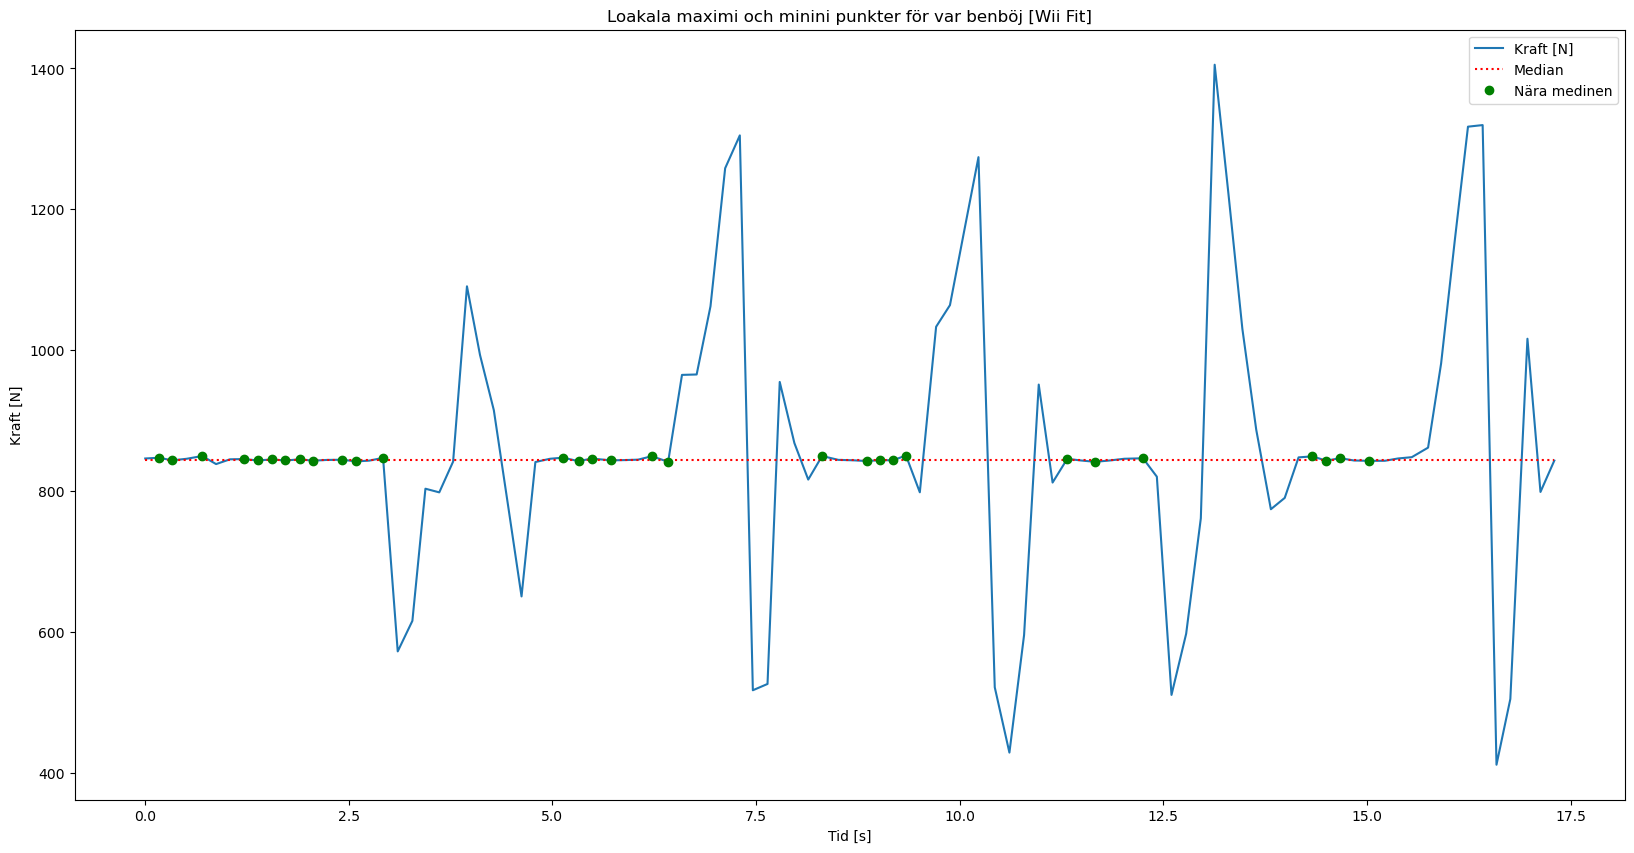

In [236]:
#Import math Library
import math

def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4


    ## Detta ska okommenteras om man vill se alla punkter
    # ax1.plot(localMaximaTime,localMaximaForce, "ro", label="Lokal Maximi")
    # ax1.plot(localMinimaTime,localMinimaForce, "go", label="Lokal Minimi")

    data0 = {
        "time":localMaximaTime,
        "force":localMaximaForce,
        "maxima":True
    }
    data1 = {
        "time":localMinimaTime,
        "force":localMinimaForce,
        "maxima":False
    }
    
    df0 = pd.DataFrame(data0)
    df1 = pd.DataFrame(data1)
    dfFull = pd.concat([df0,df1])
    dfFull.sort_values(by='time')
    
    minimaForce0 = []
    minimaTime0 = []
    
    #for row in dfFull:
    # Titta om man är vid "near" ett visst värde.
    # Kolla toppar, och bottar. På något vis....   
    

    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    #ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]


    ## Test för att se om det går att hitta om det är nära Medianen.
    closeToMedianPointsForce = []
    closeToMedianPointsTime = []
    i = 0
    tolerance = 23
    while(i < len(dataframeMinima['minima'])):
        if(math.isclose(dataframeMinima['minima'][i], sliceOfData['force'].mean(), abs_tol=tolerance)):
            closeToMedianPointsForce.append(dataframeMinima['minima'][i])
            closeToMedianPointsTime.append(dataframeMinima['time'][i])
        i = i + 1
    
    i = 0
    while(i < len(dataframeMaxima['maxima'])):
        if(math.isclose(dataframeMaxima['maxima'][i], sliceOfData['force'].mean(), abs_tol=tolerance)):
            closeToMedianPointsForce.append(dataframeMaxima['maxima'][i])
            closeToMedianPointsTime.append(dataframeMaxima['time'][i])
        i = i + 1
    
    ax1.plot(closeToMedianPointsTime,closeToMedianPointsForce, 'go', label="Nära medinen")
                
    #ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")

    #averageMaxForce = maximaForce.mean()
    #averageMinForce = minimaForce.mean()

    #ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    #ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    #ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    #ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()

#showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=200, title="Unity", nrOfSquats=9)
showMaximaAndMinimaForDataframe(dataframe=wiiFitDF, rangeTo=100, title="Wii Fit", nrOfSquats=4)



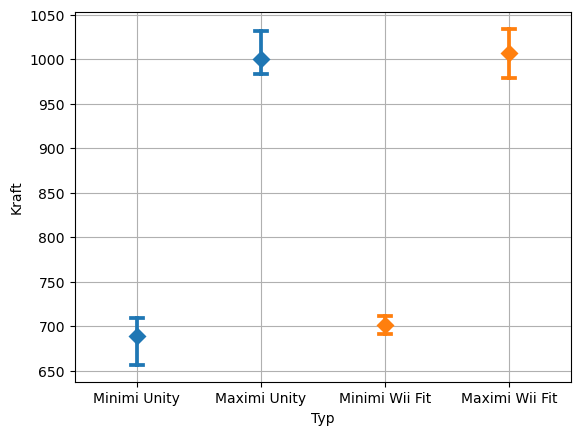

In [24]:
def concatIntoDF(minimaForce, maximaForce, name):
    data0 = {
        "Typ":f"Minimi {name}",
        "Kraft":minimaForce,
    }

    data1 = {
        "Typ":f"Maximi {name}",
        "Kraft":maximaForce,
    }

    plottedDataFrame0 = pd.DataFrame(data=data0)
    plottedDataFrame1 = pd.DataFrame(data=data1)

    plottedDataFrame = pd.concat([plottedDataFrame0, plottedDataFrame1])
    return plottedDataFrame


def showPointPlot(minimaForce0, maximaForce0, minimaForce1, maximaForce1):
    plottedUnityDataFrame = concatIntoDF(minimaForce0, maximaForce0, "Unity")
    plottedWiiFitDataFrame = concatIntoDF(minimaForce1, maximaForce1, "Wii Fit")


    fig, ax =plt.subplots(1,1)
    sns.pointplot(data=plottedUnityDataFrame, x="Typ", y="Kraft", linestyles='none', markers='D', capsize=.1, legend=True)
    sns.pointplot(data=plottedWiiFitDataFrame, x="Typ", y="Kraft", linestyles='none', markers='D', capsize=.1, legend=True)
    plt.grid()
    
    
showPointPlot(minimaForceUnity, maximaForceUnity, minimaForceWiiFit, maxmiaForceWiiFit)
